<div class="alert alert-danger">

# PSL Intensive Week: AI for Economics and Finance
## Sylvain BENOIT -- Maître de Conférences en Economie (LEDa-SDFi)
### Université Paris Dauphine - PSL
    
### Part 3: Model construction to evaluate Tax Shortfall on hidden work.
    
### 1/12/2023

</div>

<table align="left">
  <td>
    <a target="_blank" href="https://drive.google.com/file/d/1LSiqoUZKdOGktPhdkWBThICeSsgSKZBE/view?usp=share_link"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

<div class="alert alert-warning">
    
## Introduction

Banulescu-Radu, D.,Benoit, S., Hurlin, C., [Shortfall in Tax Revenue: Evaluating the Social Security Contribution Fraud](https://www.dropbox.com/scl/fi/hvpakdj3oyiwx31lge5jj/BanulescuBenoitHurlin_ShortfallinTaxRevenue_WP_2023.pdf?rlkey=dy40tiynx8qnpcpj31utnujcw&dl=0), Working Paper, 2023.
    
[Link to the presentation.](https://www.dropbox.com/scl/fi/827t12h38rbjmfi6vjz1g/Slides_IntensiveWeek_BENOIT_STaX_HW.pdf?rlkey=9z1o2j23abgrcrb2ye6q2b1e1&dl=0)

[Link to Fake Databases.](https://www.dropbox.com/scl/fo/zf38z8q2gd3uco2012x1b/h?rlkey=59sl385sz2v6ok0curcnq0izi&dl=0)

</div>

# Table of contents <a id='section_0'></a>
* [Packages](#section_1)
* [Datasets on unreported work](#section_2)
* [Useful functions for the analysis](#section_3)
* [Step 1 : Model for Fraud detection](#section_4)
    * [Variables selection](#section_4.1)
    * [Tools for evaluating a classifier](#section_4.2)
    * [Random Forest and XGBoost Classifiers](#section_4.3)
    * [Cross-validation and fine-tuning of hyper-parameters](#section_4.4)
    * [Estimation on the entire database](#section_4.5)
    * [XAI](#section_4.6)
* [Step 2: Projection on the basis of non-controlled customers](#section_5)
    * [Contingency table to analyse controls and fraud rates by sectors on the controlled samples](#section_5.1)
    * [Random forest to explain the amount of fraud on the controlled population](#section_5.2)
    * [XAI](#section_5.3)
    * [Projection based on uncontrolled with threshold adjustment](#section_5.4)
    * [Projection on the basis of non-controlled with a threshold of 0.5](#section_5.5)
    * [Projection on the basis of uncontrolled with a sweep over the threshold](#section_5.6)
    * [Conclusion](#section_5.7)
* [Step 3: Semi-supervised approach](#section_6)
    * [Creation of an alternative classifier for the semi-supervised self-trained approach](#section_6.1)
    * [Self-training Classifier](#section_6.2)
    * [Label Spreading](#section_6.3)

# Packages <a id='section_1'></a>

In [1]:
# Importation packages
import pandas as pd
import numpy as np
import imblearn #unbalanced data

# Importing the metrics package from sklearn library
from sklearn import metrics
# Importing directly the function roc_curve and auc from the metrics package
from sklearn.metrics import roc_curve, auc, precision_recall_curve, mean_squared_error, r2_score
# Importing the preprocessing package from sklearn library
from sklearn import preprocessing 
# Importing the train_test_split command
from sklearn.model_selection import train_test_split
# To use repeatedStratifiedKFold, cross-validation, grid-search
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV

# Random Forest and AdaBoost Classifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# XGBoost Classifier and regressor
import xgboost as xgb

# Semi-supervised ML, Label propagation
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier

# Data vizz
import matplotlib.pyplot as plt


# Datasets on unreported work <a id='section_2'></a>

*[Back to Table of contents](#section_0)*

In [2]:
# Path to the folder where you store the databases
path = 'C:/Users/sbenoit/Dropbox/Dauphine-SDFi/MyNotebook_Jupyter/Python_MAG/Data_IntensiveWeek/'

Variables names

In [3]:
Labels_X_SISAL = pd.read_excel(path + 'Fake_Documentation_base_estimation_td_avril2023.xlsx', sheet_name='Label_variables', skiprows=1)
Labels_X_SISAL = Labels_X_SISAL[['Variable','Label']].T
Labels_X_SISAL = Labels_X_SISAL.set_axis(Labels_X_SISAL.iloc[0], axis=1)
Labels_X_SISAL = Labels_X_SISAL.drop(Labels_X_SISAL.index[0])
Labels_X_SISAL = Labels_X_SISAL.set_index([pd.Index([0])])
Labels_X_SISAL

Variable,tot_mtt_redrest_tot,ccdrpdta,ancentr,lucea,mensu,nbtesa,pcdi,age_moy,age_ec,anc_moy,...,nbviecdi,nbviecdd,coti_etat,coti_emp,emb_mrmcdi,emb_heucdi,embcdd,emb_mrmcdd,emb_heucdd,ctrl_2014
0,Montant de redressement total,Catégorie de risque prépondérant AT de l'entre...,Ancienneté de l'entreprise,LUCEA O/N,MENSU,Nombre de Tesa,% salariés en CDI,Age moyen du salarié,Ecart-type de l'âge du salarié,Ancienneté moyenne du salarié au sein de l'ent...,...,Nombre de CDI encore en vie au 31/12/AAAA,Nombre de CDD encore en vie au 31/12/AAAA,Montant cotisations prises en charge par l'Etat,Montant cotisations payées par l'employeur,Montant rémunération embauchés en cdi,Nb heures embauchés en cdi,Nb embauchés en cdd,Montant rémunération embauchés en cdd,Nb heures embauchés en cdd,"=1 si l'entreprise est contrôlée, 0 sinon"


Importation of the database SISAL APPA with selected variables

First database.

In [4]:
Data_final_num_annual = pd.read_excel(path + 'Fake_DataAnnual_SISAL_final_num.xlsx')
print(type(Data_final_num_annual))
print(Data_final_num_annual.shape)

<class 'pandas.core.frame.DataFrame'>
(162390, 20)


In [5]:
Columns_Name_num_annual = Data_final_num_annual.columns
Columns_Name_num_annual

Index(['mensu_num', 'ccdrpdta15cl_num', 'classif_algo_num', 'ancentr', 'pcdi',
       'age_ec', 'anc_moy', 'anc_ec', 'sal_moy', 'sal_ec', 'heu_tec',
       'heu_bur', 'sal_fem', 'coti_etat', 'nombre_mensuel_moyen_sal',
       'nbsaison', 'emb_heucdd', 'nbsal', 'Fraude_num', 'Montants'],
      dtype='object')

Second database.

In [6]:
Data_final_modified_annual = pd.read_excel(path + 'Fake_DataAnnual_SISAL_final_numcat_dicho.xlsx')
print(type(Data_final_modified_annual))
print(Data_final_modified_annual.shape)

<class 'pandas.core.frame.DataFrame'>
(162390, 47)


In [7]:
Columns_Name_modified_annual = Data_final_modified_annual.columns
Columns_Name_modified_annual

Index(['mensu_dum', 'Activités diverses_dum', 'Champignonnières_dum',
       'Conchyliculture_dum', 'Culture et élevage non spécialisés_dum',
       'Cultures spécialisées_dum', 'Elevage spécialisés gros animaux_dum',
       'Elevage spécialisés petits animaux_dum',
       'Entrainement, dressage, haras_dum',
       'Entreprises d'artisanat rural_dum', 'Entreprises de coopération_dum',
       'Entreprises de travaux agricoles_dum', 'Marais salants_dum',
       'Organismes de service_dum', 'Travaux forestiers_dum',
       'Viticulture_dum', 'Act. diverses et Org. service_dum',
       'Culture et élevage non spécialisés 0111Z_dum',
       'Culture et élevage non spécialisés autres_dum',
       'Culture et élevage non spécialisés bovins_dum',
       'Cultures spécialisées 0111Z_dum', 'Cultures spécialisées 0113Z_dum',
       'Cultures spécialisées 0124Z_dum', 'Cultures spécialisées 0130Z_dum',
       'Cultures spécialisées autres_dum',
       'Entreprises de travaux agricoles 0161Z_dum',


Third database.

In [8]:
Data_final_for_analysis_annual = pd.read_excel(path + 'Fake_DataAnnual_SISAL_final_for_analysis.xlsx')
print(type(Data_final_for_analysis_annual))
print(Data_final_for_analysis_annual.shape)

<class 'pandas.core.frame.DataFrame'>
(162390, 10)


In [9]:
# Replace 0 by NaN
Data_final_for_analysis_annual['ctrl_2014'].replace(0, np.nan, inplace=True)
# change the name of the variable
Data_final_for_analysis_annual = Data_final_for_analysis_annual.rename(columns = {"ctrl_2014": "Ctrl_num"})  # Using rename()

In [10]:
Columns_Name_for_analysis_annual = Data_final_for_analysis_annual.columns
Columns_Name_for_analysis_annual

Index(['ccdrpdta15cl', 'classif_algo', 'masse_tot', 'coti_tot',
       'Ratio_masse_tot', 'Ratio_coti_tot', 'Ctrl_num', 'Fraude', 'Fraude_num',
       'Montants'],
      dtype='object')

# Useful functions for the analysis <a id='section_3'></a>

*[Back to Table of contents](#section_0)*

In [11]:
def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

In [12]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from: Hands-On Machine learning with Scikit-Learn and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [13]:
# Creating a function to report confusion metrics
def confusion_metrics(conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1 - conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate F_1 score
    conf_F1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'F_1 Score: {round(conf_F1,2)}')

In [14]:
def my_cross_val_predict(
            clf, X, y, cv=RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
            ):

        scores = []

        for i, (train_index, test_index) in enumerate(cv.split(X_controlled, Y_fraudster_controlled)):
            X_app = X.iloc[train_index, :]
            X_val = X.iloc[test_index, :]
            Y_app = y.iloc[train_index]
            Y_val = y.iloc[test_index]
            clf.fit(X_app, Y_app)
            # Calcul de la proba de fraude (première colone, proba d'être non fraudeur - 0; seconde colone, proba d'être fraudeur - 1)
            Y_app_clf_prob = clf.predict_proba(X_app)
            Y_val_clf_prob = clf.predict_proba(X_val)
            # Récupération du seuil optimal
#             print(np.mean(Y_app))
            threshold = np.quantile(Y_app_clf_prob[:, 1], 1-np.mean(Y_app))
#             print(threshold)
            Y_app_clf_pred = (Y_app_clf_prob[:,1] >= threshold).astype('int')
#             print(confusion_metrics(metrics.confusion_matrix(Y_app, Y_app_clf_pred)))
            Y_val_clf_pred = (Y_val_clf_prob[:,1] >= threshold).astype('int')
            conf_matrix_val = metrics.confusion_matrix(Y_val, Y_val_clf_pred)
#             print(confusion_metrics(conf_matrix_val))
            [[TN, FP], [FN, TP]] = conf_matrix_val
            sensitivity_val = (TP / float(TP + FN))
#             print(sensitivity_val)
            scores.append(sensitivity_val)
    
        return np.mean(scores)

In [15]:
def my_cross_val_predict_knn(
            clf, X, y, cv=RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
            ):

        scores_app = []
        scores_val = []

        for i, (train_index, test_index) in enumerate(cv.split(X_controlled, Y_fraudster_controlled)):
            X_app = X.iloc[train_index, :]
            X_val = X.iloc[test_index, :]
            Y_app = y.iloc[train_index]
            Y_val_true = y.iloc[test_index]
#             print(Y_val_true)
#             print(Y_val_true.dtypes)
            Y_val = pd.Series(-np.ones(len(test_index)), index = Y_val_true.index, name = 'Fraude_num')
#             print(Y_val)
            
            XY_ss_labelled = pd.concat([X_app, Y_app], axis = 1)
            XY_ss_unlabelled = pd.concat([X_val, Y_val], axis = 1)
            
            XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
            label_spread_clf = clf.fit(XY_spread.drop(['Fraude_num'], axis = 1), XY_spread['Fraude_num'])

            Y_app_clf_pred = pd.DataFrame((label_spread_clf.transduction_[(XY_spread['Fraude_num'] != -1)]==1).astype('int'), index = XY_spread[(XY_spread['Fraude_num'] != -1)].index, columns = ['Fraude_pred'])
            
            [[TN, FP], [FN, TP]] = metrics.confusion_matrix(Y_app, Y_app_clf_pred)
            sensitivity_app = (TP / float(TP + FN))
    #             print(sensitivity_app_clf2)
            scores_app.append(sensitivity_app)
            
            # Fraudsters prediction on the val database to determine who could be a fraudster, we predict the class here by looking at the pseudo labels
            Y_val_clf_pred = pd.DataFrame((label_spread_clf.transduction_[(XY_spread['Fraude_num'] == -1)]==1).astype('int'), index = XY_spread[(XY_spread['Fraude_num'] == -1)].index, columns = ['Fraude_pred'])
            print(f"The number of pseudo-labelled fraudsters in the validation sample is {np.sum(label_spread_clf.transduction_[(XY_spread['Fraude_num'] == -1)]== 1).astype('int')}")
            print(f"The number of pseudo-labelled non-fraudsters in the validation sample is {np.sum(label_spread_clf.transduction_[(XY_spread['Fraude_num'] == -1)]== 0).astype('int')}")
            print(f"The number of non-pseudo-labeled in the validation sample is {np.sum(label_spread_clf.transduction_[(XY_spread['Fraude_num'] == -1)]== -1).astype('int')}")
            print(f'Label spreading done on fold number {i+1}')

            conf_matrix_val = metrics.confusion_matrix(Y_val_true, Y_val_clf_pred)
#             print(confusion_metrics(conf_matrix_val))
            [[TN, FP], [FN, TP]] = conf_matrix_val
            sensitivity_val = (TP / float(TP + FN))
#             print(sensitivity_val)
            scores_val.append(sensitivity_val)
    
            print(f"  Sensibility Train./Val. : ={sensitivity_app, sensitivity_val}")
    
        return [np.mean(scores_app), np.mean(scores_val)]

In [16]:
def my_cross_val_predict_2clf(
            clf1, clf2, X, y, cv=RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
            ):

        scores_app_clf1 = []
        scores_val_clf1 = []
        scores_app_clf2 = []
        scores_val_clf2 = []

        for i, (train_index, test_index) in enumerate(cv.split(X_controlled, Y_fraudster_controlled)):
            print(f"Fold {i}:")
            X_app = X.iloc[train_index, :]
            X_val = X.iloc[test_index, :]
            Y_app = y.iloc[train_index]
            Y_val = y.iloc[test_index]
            
            clf1.fit(X_app, Y_app)
            # Calcul de la proba de fraude (première colone, proba d'être non fraudeur - 0; seconde colone, proba d'être fraudeur - 1)
            Y_app_clf1_prob = clf1.predict_proba(X_app)
            Y_val_clf1_prob = clf1.predict_proba(X_val)
            # Récupération du seuil optimal
            print(f"Fraud rate in the training set. {np.mean(Y_app)}:")
            threshold = np.quantile(Y_app_clf1_prob[:, 1], 1-np.mean(Y_app))
#             print(threshold)
            Y_app_clf1_pred = (Y_app_clf1_prob[:,1] >= threshold).astype('int')
#             print(confusion_metrics(metrics.confusion_matrix(Y_app, Y_app_clf1_pred)))
            [[TN, FP], [FN, TP]] = metrics.confusion_matrix(Y_app, Y_app_clf1_pred)
            sensitivity_app_clf1 = (TP / float(TP + FN))
#             print(sensitivity_app_clf1)
            scores_app_clf1.append(sensitivity_app_clf1)
            Y_val_clf1_pred = (Y_val_clf1_prob[:,1] >= threshold).astype('int')
            conf_matrix_val_clf1 = metrics.confusion_matrix(Y_val, Y_val_clf1_pred)
#             print(confusion_metrics(conf_matrix_val))
            [[TN, FP], [FN, TP]] = conf_matrix_val_clf1
            sensitivity_val_clf1 = (TP / float(TP + FN))
#             print(sensitivity_val)
            scores_val_clf1.append(sensitivity_val_clf1)
            print(f"  Sensibility Clf1 Train./Val. : ={sensitivity_app_clf1, sensitivity_val_clf1}")
        
            clf2.fit(X_app, Y_app)
            # Calcul de la proba de fraude (première colone, proba d'être non fraudeur - 0; seconde colone, proba d'être fraudeur - 1)
            Y_app_clf2_prob = clf2.predict_proba(X_app)
            Y_val_clf2_prob = clf2.predict_proba(X_val)
            # Récupération du seuil optimal
#             print(np.mean(Y_app))
            threshold = np.quantile(Y_app_clf2_prob[:, 1], 1-np.mean(Y_app))
#             print(threshold)
            Y_app_clf2_pred = (Y_app_clf2_prob[:,1] >= threshold).astype('int')
#             print(confusion_metrics(metrics.confusion_matrix(Y_app, Y_app_clf2_pred)))
            [[TN, FP], [FN, TP]] = metrics.confusion_matrix(Y_app, Y_app_clf2_pred)
            sensitivity_app_clf2 = (TP / float(TP + FN))
#             print(sensitivity_app_clf2)
            scores_app_clf2.append(sensitivity_app_clf2)
            Y_val_clf2_pred = (Y_val_clf2_prob[:,1] >= threshold).astype('int')
            conf_matrix_val_clf2 = metrics.confusion_matrix(Y_val, Y_val_clf2_pred)
#             print(confusion_metrics(conf_matrix_val))
            [[TN, FP], [FN, TP]] = conf_matrix_val_clf2
            sensitivity_val_clf2 = (TP / float(TP + FN))
#             print(sensitivity_val_clf2)
            scores_val_clf2.append(sensitivity_val_clf2)
            print(f"  Sensibility Clf2 Train./Val. : ={sensitivity_app_clf2, sensitivity_val_clf2}")
        
        return [[np.mean(scores_app_clf1), np.mean(scores_val_clf1)] , [np.mean(scores_app_clf2), np.mean(scores_val_clf2)]]

In [17]:
def my_gridsearch_NbTrees_cross_val_predict_2clf(
            X, y, n_estimators_grid, cv=RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
            ):

        outputs = []

        for n_estimators_value in n_estimators_grid:
        
            clf1 = xgb.XGBClassifier(objective="binary:logistic", n_estimators = n_estimators_value, max_depth = 6, random_state=42, eval_metric="logloss")
            clf2 = RandomForestClassifier(n_estimators=n_estimators_value, max_depth = 6, random_state=42) 
                
            print(f"n_estimators {n_estimators_value} and max_depth 6:") 

            scores_app_clf1 = []
            scores_val_clf1 = []
            scores_app_clf2 = []
            scores_val_clf2 = []
        
            for i, (train_index, test_index) in enumerate(cv.split(X_controlled, Y_fraudster_controlled)):
            
                print(f"Fold {i}:")
                X_app = X.iloc[train_index, :]
                X_val = X.iloc[test_index, :]
                Y_app = y.iloc[train_index]
                Y_val = y.iloc[test_index]
                
                clf1.fit(X_app, Y_app)
                # Calculation of fraud proba (first column, proba of being a non-frauder - 0; second column, proba of being a fraudster - 1)                
                Y_app_clf1_prob = clf1.predict_proba(X_app)
                Y_val_clf1_prob = clf1.predict_proba(X_val)
                # Get the optimal threshold
                print(f"Fraud rate in the training set. {np.mean(Y_app)}:")
                threshold = np.quantile(Y_app_clf1_prob[:, 1], 1-np.mean(Y_app))
    #             print(threshold)
                Y_app_clf1_pred = (Y_app_clf1_prob[:,1] >= threshold).astype('int')
    #             print(confusion_metrics(metrics.confusion_matrix(Y_app, Y_app_clf1_pred)))
                [[TN, FP], [FN, TP]] = metrics.confusion_matrix(Y_app, Y_app_clf1_pred)
                sensitivity_app_clf1 = (TP / float(TP + FN))
    #             print(sensitivity_app_clf1)
                scores_app_clf1.append(sensitivity_app_clf1)
                Y_val_clf1_pred = (Y_val_clf1_prob[:,1] >= threshold).astype('int')
                conf_matrix_val_clf1 = metrics.confusion_matrix(Y_val, Y_val_clf1_pred)
    #             print(confusion_metrics(conf_matrix_val))
                [[TN, FP], [FN, TP]] = conf_matrix_val_clf1
                sensitivity_val_clf1 = (TP / float(TP + FN))
    #             print(sensitivity_val)
                scores_val_clf1.append(sensitivity_val_clf1)
                print(f"  Sensibility Clf1 Train./Val. : ={sensitivity_app_clf1, sensitivity_val_clf1}")
        
                clf2.fit(X_app, Y_app)
                # Calculation of fraud proba (first column, proba of being a non-frauder - 0; second column, proba of being a fraudster - 1)
                Y_app_clf2_prob = clf2.predict_proba(X_app)
                Y_val_clf2_prob = clf2.predict_proba(X_val)
                # Save the optimal threshold
    #             print(np.mean(Y_app))
                threshold = np.quantile(Y_app_clf2_prob[:, 1], 1-np.mean(Y_app))
    #             print(threshold)
                Y_app_clf2_pred = (Y_app_clf2_prob[:,1] >= threshold).astype('int')
    #             print(confusion_metrics(metrics.confusion_matrix(Y_app, Y_app_clf2_pred)))
                [[TN, FP], [FN, TP]] = metrics.confusion_matrix(Y_app, Y_app_clf2_pred)
                sensitivity_app_clf2 = (TP / float(TP + FN))
    #             print(sensitivity_app_clf2)
                scores_app_clf2.append(sensitivity_app_clf2)
                Y_val_clf2_pred = (Y_val_clf2_prob[:,1] >= threshold).astype('int')
                conf_matrix_val_clf2 = metrics.confusion_matrix(Y_val, Y_val_clf2_pred)
    #             print(confusion_metrics(conf_matrix_val))
                [[TN, FP], [FN, TP]] = conf_matrix_val_clf2
                sensitivity_val_clf2 = (TP / float(TP + FN))
    #             print(sensitivity_val_clf2)
                scores_val_clf2.append(sensitivity_val_clf2)
                print(f"  Sensibility Clf2 Train./Val. : ={sensitivity_app_clf2, sensitivity_val_clf2}")
                    
            output = [[n_estimators_value, np.mean(scores_app_clf1), np.mean(scores_val_clf1)], [n_estimators_value, np.mean(scores_app_clf2), np.mean(scores_val_clf2)]]
            outputs.append(output)
            print(output)
            print('')
            
        return outputs

In [18]:
def my_gridsearch_MaxDepth_cross_val_predict_2clf(
            X, y, max_depth_grid, cv=RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
            ):

        outputs = []

        for max_depth_value in max_depth_grid:
            
            # clf1 = xgb.XGBClassifier(objective="binary:logistic", n_estimators = 500, max_depth = max_depth_value, random_state=42, eval_metric="logloss", use_label_encoder=False)
            clf1 = xgb.XGBClassifier(objective="binary:logistic", n_estimators = 500, max_depth = max_depth_value, random_state=42, eval_metric="logloss")
            clf2 = RandomForestClassifier(n_estimators = 500, max_depth = max_depth_value, random_state=42)
                
            print(f"n_estimators 500 and max_depth {max_depth_value}:") 
            
            scores_app_clf1 = []
            scores_val_clf1 = []
            scores_app_clf2 = []
            scores_val_clf2 = []
        
            for i, (train_index, test_index) in enumerate(cv.split(X_controlled, Y_fraudster_controlled)):
            
                print(f"Fold {i}:")
                X_app = X.iloc[train_index, :]
                X_val = X.iloc[test_index, :]
                Y_app = y.iloc[train_index]
                Y_val = y.iloc[test_index]
                
                clf1.fit(X_app, Y_app)
                # Calcul de la proba de fraude (première colone, proba d'être non fraudeur - 0; seconde colone, proba d'être fraudeur - 1)
                Y_app_clf1_prob = clf1.predict_proba(X_app)
                Y_val_clf1_prob = clf1.predict_proba(X_val)
                # Récupération du seuil optimal
                print(f"Taux de fraude dans la base d'App. {np.mean(Y_app)}:")
                threshold = np.quantile(Y_app_clf1_prob[:, 1], 1-np.mean(Y_app))
    #             print(threshold)
                Y_app_clf1_pred = (Y_app_clf1_prob[:,1] >= threshold).astype('int')
    #             print(confusion_metrics(metrics.confusion_matrix(Y_app, Y_app_clf1_pred)))
                [[TN, FP], [FN, TP]] = metrics.confusion_matrix(Y_app, Y_app_clf1_pred)
                sensitivity_app_clf1 = (TP / float(TP + FN))
    #             print(sensitivity_app_clf1)
                scores_app_clf1.append(sensitivity_app_clf1)
                Y_val_clf1_pred = (Y_val_clf1_prob[:,1] >= threshold).astype('int')
                conf_matrix_val_clf1 = metrics.confusion_matrix(Y_val, Y_val_clf1_pred)
    #             print(confusion_metrics(conf_matrix_val))
                [[TN, FP], [FN, TP]] = conf_matrix_val_clf1
                sensitivity_val_clf1 = (TP / float(TP + FN))
    #             print(sensitivity_val)
                scores_val_clf1.append(sensitivity_val_clf1)
                print(f"  Sensibilité Clf1 App./Val. : ={sensitivity_app_clf1, sensitivity_val_clf1}")
        
                clf2.fit(X_app, Y_app)
                # Calcul de la proba de fraude (première colone, proba d'être non fraudeur - 0; seconde colone, proba d'être fraudeur - 1)
                Y_app_clf2_prob = clf2.predict_proba(X_app)
                Y_val_clf2_prob = clf2.predict_proba(X_val)
                # Récupération du seuil optimal
    #             print(np.mean(Y_app))
                threshold = np.quantile(Y_app_clf2_prob[:, 1], 1-np.mean(Y_app))
    #             print(threshold)
                Y_app_clf2_pred = (Y_app_clf2_prob[:,1] >= threshold).astype('int')
    #             print(confusion_metrics(metrics.confusion_matrix(Y_app, Y_app_clf2_pred)))
                [[TN, FP], [FN, TP]] = metrics.confusion_matrix(Y_app, Y_app_clf2_pred)
                sensitivity_app_clf2 = (TP / float(TP + FN))
    #             print(sensitivity_app_clf2)
                scores_app_clf2.append(sensitivity_app_clf2)
                Y_val_clf2_pred = (Y_val_clf2_prob[:,1] >= threshold).astype('int')
                conf_matrix_val_clf2 = metrics.confusion_matrix(Y_val, Y_val_clf2_pred)
    #             print(confusion_metrics(conf_matrix_val))
                [[TN, FP], [FN, TP]] = conf_matrix_val_clf2
                sensitivity_val_clf2 = (TP / float(TP + FN))
    #             print(sensitivity_val_clf2)
                scores_val_clf2.append(sensitivity_val_clf2)
                print(f"  Sensibility Clf2 Train./Val. : ={sensitivity_app_clf2, sensitivity_val_clf2}")
                    
            output = [[max_depth_value, np.mean(scores_app_clf1), np.mean(scores_val_clf1)], [max_depth_value, np.mean(scores_app_clf2), np.mean(scores_val_clf2)]]
            outputs.append(output)
            print(output)
            print('')
            
        return outputs

In [19]:
def highlight_cols(forecast):
    color = 'lightblue'
    return 'background-color: %s' % color

# Step 1 : Model for Fraud detection <a id='section_4'></a>

*[Back to Table of contents](#section_0)*

## Variables selection <a id='section_4.1'></a>

In [20]:
Data_Xcat_annual = Data_final_num_annual[['mensu_num', 'classif_algo_num']]
Data_Xnumcat_annual = Data_final_modified_annual[['ancentr_deciles', 'pcdi_deciles', 'age_ec_deciles',
       'anc_moy_deciles', 'anc_ec_deciles', 'sal_moy_deciles',
       'sal_ec_deciles', 'heu_tec_deciles', 'heu_bur_deciles',
       'sal_fem_deciles', 'coti_etat_deciles',
       'nombre_mensuel_moyen_sal_deciles', 'nbsaison_deciles',
       'emb_heucdd_deciles', 'nbsal_deciles']]
Data_Y_annual = Data_final_for_analysis_annual[['Montants', 'Ctrl_num', 'Fraude_num']]

In [21]:
Data_appa = pd.concat([Data_Xcat_annual, Data_Xnumcat_annual, Data_Y_annual], axis = 1)

In [22]:
# Check if we have missing value
Data_appa.isna().sum()

mensu_num                                0
classif_algo_num                         0
ancentr_deciles                          0
pcdi_deciles                             0
age_ec_deciles                           0
anc_moy_deciles                          0
anc_ec_deciles                           0
sal_moy_deciles                          0
sal_ec_deciles                           0
heu_tec_deciles                          0
heu_bur_deciles                          0
sal_fem_deciles                          0
coti_etat_deciles                        0
nombre_mensuel_moyen_sal_deciles         0
nbsaison_deciles                         0
emb_heucdd_deciles                       0
nbsal_deciles                            0
Montants                            161894
Ctrl_num                            160000
Fraude_num                          160000
dtype: int64

In [23]:
# Création du chemin physique pour aller lire les bases de données
# path = 'F:/Dropbox/D.Former/2023 MSA/Data_Nov22/Data_Avril_2023/'
# Exportation de la base de données
# Data_appa.to_excel(path + 'DataAnnual_appa_for_denisa.xlsx', index = False)

In [24]:
Data_appa['mensu_num'].sum()

12351

In [25]:
base_controlled = Data_appa[Data_appa['Ctrl_num'].notna()]
print(base_controlled.shape)
base_uncontrolled = Data_appa[Data_appa['Ctrl_num'].isna()]
print(base_uncontrolled.shape)

(2390, 20)
(160000, 20)


In [26]:
# Base de TRAIN
X_controlled = base_controlled.drop(['Montants','Ctrl_num','Fraude_num'], axis = 1)
print(X_controlled.shape)
# Base de TEST
X_uncontrolled = base_uncontrolled.drop(['Montants','Ctrl_num','Fraude_num'], axis = 1)
print(X_uncontrolled.shape)

(2390, 17)
(160000, 17)


In [27]:
Y_fraudster_controlled = base_controlled[base_controlled['Ctrl_num'].notna()]['Fraude_num']
# Nb of controls
print(Y_fraudster_controlled.shape)
print(sum(Y_fraudster_controlled))

(2390,)
496.0


In [28]:
# Percentage of fraudsters in the controlled population
print(np.mean(base_controlled['Fraude_num']))

0.20753138075313807


## Tools for evaluating a classifier <a id='section_4.2'></a>

### The Confusion Matrix

<div class="alert alert-info">
    
|     | <p style="color:blue;">Predicted Negative </p> | <p style="color:blue;"> Predicted Positive </p> |
|-----|-----|--------|
| <p style="color:red;">**Actual Negative** </p> | **TN** | **FP** |
| <p style="color:red;">**Actual Positive** </p> | **FN** | **TP** |

*Positive* in this case is the class of interest . For example, “identifying a fraudulent transaction”.

*True Positive (TP):* when the model predicted as Positive, and they were actually Positive (e.g. a fraudulent transaction is identified as fraudulent).

*True Negative (TN):* when the model predicted as Negative, and they were actually Negative (e.g. a non-fraudulent transaction is identified as non-fraudulent).

*False Positive (FP) (aka Type I Error):* when the model predicted as Positive, but they were in fact Negative (e.g. a non-fraudulent transaction is identified as fraudulent).

*False Negative (FN) (aka Type II Error):* when the model predicted as Negative, but they were Positive(e.g. a fraudulent transaction is identified as non-fraudulent).

Usually, Type II errors (FN) have more severe consequences and in ML the goal is to minimize Type II errors. Type I errors on the other hand have less consequences. However, in an ideal case, a perfect model should have none of these errors.
    
</div>

## The Six Metrics that Matter

<div class="alert alert-info">

**Accuracy** is the proportion of correct predictions over the total number of predictions.

\begin{equation*}
    Accuracy = \frac{(TP + TN)}{All Predictions}
\end{equation*}

**Mis-Classification** is (1-Accuracy), and means all false predictions over the total number of predictions.

**Sensitivity (aka Recall)** means “out of all actual Positives, how many did we predict as Positive”, which can be explained as:

\begin{equation*}
    Sensitivity~(Recall) = \frac{TP}{(FN + TP)}
\end{equation*}

**Specificity (aka Selectivity or True Negative Rate, TNR)** means “out of all actual Negatives, how many did we predict as Negative”, and can be written as:

\begin{equation*}
    Specificity = \frac{TN}{(TN + FP)}
\end{equation*}

**Precision (aka Positive Predictive Value, PPV)** means “out of all predicted Positive cases, how many were actually Positive”, or
\begin{equation*}
    Precision = \frac{TP}{(TP + FP)}
\end{equation*}

**F1 Score** is the harmonic, or weighted, an average of Precision and Sensitivity, and is a widely used measure of accuracy for classification problems. It is calculated as:
\begin{equation*}
    F1~Score = 2 * \frac{(Precision * Sensitivity)}{(Precision + Sensitivity)}
\end{equation*}

</div>

## Area Under Curve (AUC) for The Receiver Operating Characteristic (ROC)]

<div class="alert alert-info">

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection in machine learning.
    
</div>

## Random Forest and XGBoost Classifiers <a id='section_4.3'></a>

In [29]:
# RandomForestClassifier?
# xgb.XGBClassifier?

**Random Forest**

In [30]:
fraud_clf = RandomForestClassifier(n_estimators=100, random_state=42)
fraud_clf.fit(X_controlled, Y_fraudster_controlled)

RandomForestClassifier(random_state=42)

In [31]:
# Calculation of fraud proba (first column, proba of being a non-frauder - 0; second column, proba of being a fraudster - 1)
Y_fraudster_controlled_clf_prob = fraud_clf.predict_proba(X_controlled)
# Optimum threshold recovery
threshold = np.quantile(Y_fraudster_controlled_clf_prob[:, 1], 1-np.mean(base_controlled['Fraude_num']))
Y_fraudster_controlled_clf = (Y_fraudster_controlled_clf_prob[:,1] >= threshold).astype('int')
threshold

0.3915062761506306

In [32]:
# Calculation of the fraud rate among those inspected
Y_fraudster_controlled_clf.mean()

0.20753138075313807

Another way of determining an optimal threshold is to cross-reference sensitivity with specificity.

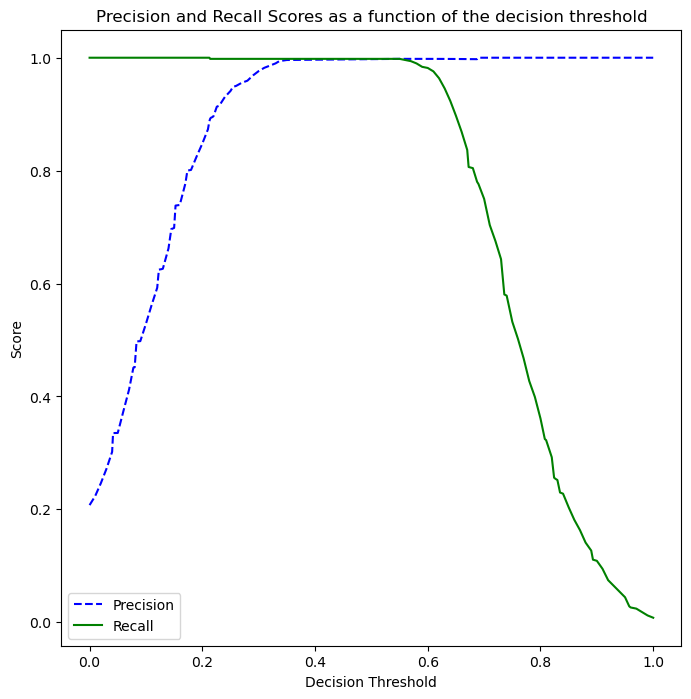

In [33]:
p, r, thresholds = precision_recall_curve(Y_fraudster_controlled, Y_fraudster_controlled_clf_prob[:,1])
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [34]:
# Creating the confusion matrix
MyConfMat = metrics.confusion_matrix(Y_fraudster_controlled, Y_fraudster_controlled_clf)
# Assigning columns names
MyConfMat_df = pd.DataFrame(MyConfMat, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
MyConfMat_df

,Predicted Negative,Predicted Positive
Actual Negative,1893,1
Actual Positive,1,495


ROC Curve and Area below the curve (AUC)

In [35]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(Y_fraudster_controlled, Y_fraudster_controlled_clf_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9998185058078142


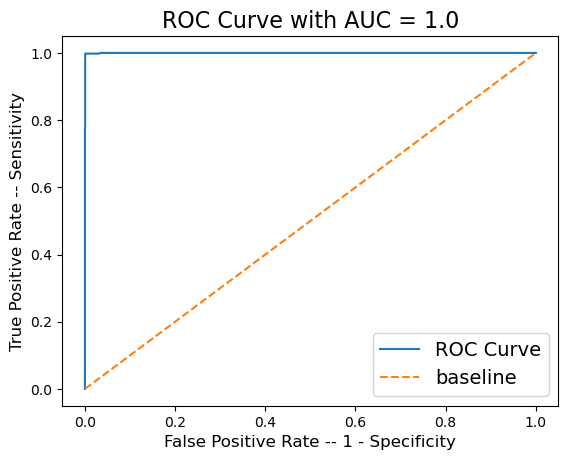

In [36]:
# Plot ROC curve.
plt.plot(fpr, tpr,
         label='ROC Curve')
# Plot baseline.
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes.
plt.title(f"ROC Curve with AUC = {round(roc_auc,3)}", fontsize=16)
plt.xlabel('False Positive Rate -- 1 - Specificity', fontsize=12)
plt.ylabel('True Positive Rate -- Sensitivity', fontsize=12)
# Create legend.
plt.legend(fontsize=14, loc='lower right');

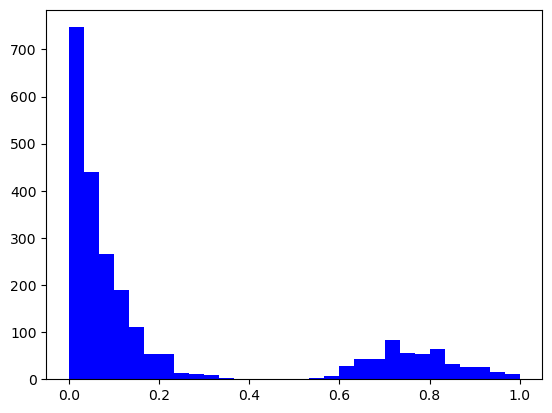

In [37]:
plt.hist(Y_fraudster_controlled_clf_prob[:,1], label ="Prob. = 1", color ="b", bins = 30)
plt.show()

It is obvious that we have to deal with **overfitting issues**.

**XGBoost**

In [38]:
#fraud_clf = xgb.XGBClassifier(objective="binary:logistic", n_estimators=100, random_state=42, eval_metric="logloss", use_label_encoder=False)
fraud_clf = xgb.XGBClassifier(objective="binary:logistic", n_estimators=100, random_state=42, eval_metric="logloss")
fraud_clf.fit(X_controlled, Y_fraudster_controlled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [39]:
# Calculation of fraud proba (first column, proba of being a non-frauder - 0; second column, proba of being a fraudster - 1)
Y_fraudster_controlled_clf_prob = fraud_clf.predict_proba(X_controlled)
# Optimum threshold recovery
threshold = np.quantile(Y_fraudster_controlled_clf_prob[:, 1], 1-np.mean(base_controlled['Fraude_num']))
Y_fraudster_controlled_clf = (Y_fraudster_controlled_clf_prob[:,1] >= threshold).astype('int')
threshold

0.43160579319279574

In [40]:
# Calculation of the fraud rate among those inspected
Y_fraudster_controlled_clf.mean()

0.20753138075313807

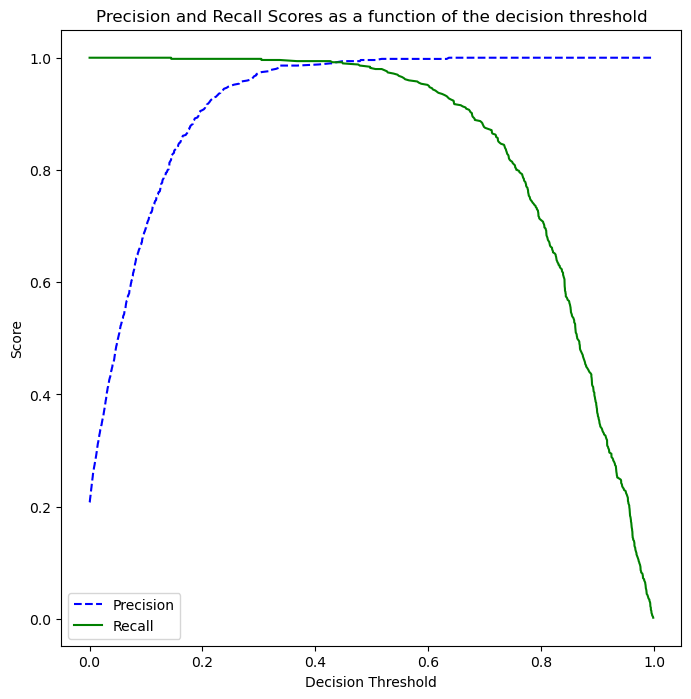

In [41]:
p, r, thresholds = precision_recall_curve(Y_fraudster_controlled, Y_fraudster_controlled_clf_prob[:,1])
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [42]:
# Creating the confusion matrix
MyConfMat = metrics.confusion_matrix(Y_fraudster_controlled, Y_fraudster_controlled_clf)
# Assigning columns names
MyConfMat_df = pd.DataFrame(MyConfMat, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
MyConfMat_df

,Predicted Negative,Predicted Positive
Actual Negative,1890,4
Actual Positive,4,492


In [43]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(Y_fraudster_controlled, Y_fraudster_controlled_clf_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9998153123616174


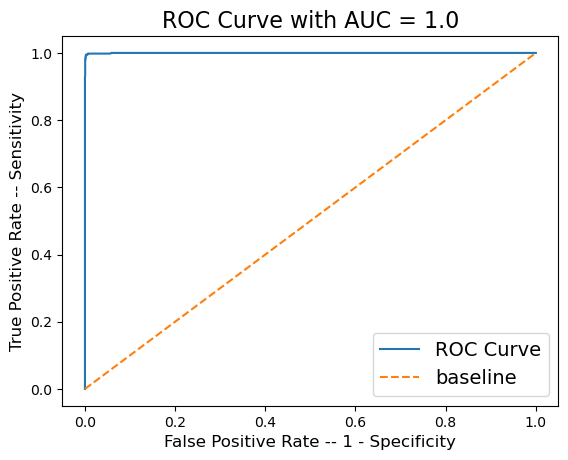

In [44]:
# Plot ROC curve.
plt.plot(fpr, tpr,
         label='ROC Curve')
# Plot baseline.
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes.
plt.title(f"ROC Curve with AUC = {round(roc_auc,3)}", fontsize=16)
plt.xlabel('False Positive Rate -- 1 - Specificity', fontsize=12)
plt.ylabel('True Positive Rate -- Sensitivity', fontsize=12)
# Create legend.
plt.legend(fontsize=14, loc='lower right');

## Cross-validation and fine-tuning of hyper-parameters <a id='section_4.4'></a>

**Cross-validation**

In [45]:
#clf1 = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="logloss", use_label_encoder=False)
clf1 = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="logloss")
clf2 = RandomForestClassifier(random_state=42)
my_cross_val_predict_2clf(clf1, clf2, X_controlled, Y_fraudster_controlled)

Fold 0:
Fraud rate in the training set. 0.20711297071129708:
  Sensibility Clf1 Train./Val. : =(0.9974747474747475, 0.3)
  Sensibility Clf2 Train./Val. : =(0.9974747474747475, 0.39)
Fold 1:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.9949622166246851, 0.3838383838383838)
  Sensibility Clf2 Train./Val. : =(1.0, 0.25252525252525254)
Fold 2:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.9949622166246851, 0.4444444444444444)
  Sensibility Clf2 Train./Val. : =(0.9974811083123426, 0.47474747474747475)
Fold 3:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.9949622166246851, 0.3939393939393939)
  Sensibility Clf2 Train./Val. : =(0.9974811083123426, 0.3434343434343434)
Fold 4:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.9974811083123426, 0.41414141414141414)
  Sensibility Clf2 Train./Val. : =(0.9974811083123426, 0.3434

[[0.9959685011322291, 0.38727272727272727],
 [0.9979836144823551, 0.36082828282828283]]

 **Both the RF and XGboost models have the same overfitting problems, but we haven't controlled for tree depth in the `RandomForestClassifier`.**

**Fine-tuning of hyper-parameters**

For a given tree depth (`max_depth`=6), we'll play with the number of trees in the `n_estimators` forest.

In [46]:
my_gridsearch_NbTrees_cross_val_predict_2clf(X_controlled, Y_fraudster_controlled, n_estimators_grid = [100, 500, 1500, 3000])

n_estimators 100 and max_depth 6:
Fold 0:
Fraud rate in the training set. 0.20711297071129708:
  Sensibility Clf1 Train./Val. : =(0.9974747474747475, 0.3)
  Sensibility Clf2 Train./Val. : =(0.6237373737373737, 0.49)
Fold 1:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.9949622166246851, 0.3838383838383838)
  Sensibility Clf2 Train./Val. : =(0.6246851385390428, 0.5050505050505051)
Fold 2:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.9949622166246851, 0.4444444444444444)
  Sensibility Clf2 Train./Val. : =(0.5994962216624685, 0.5454545454545454)
Fold 3:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.9949622166246851, 0.3939393939393939)
  Sensibility Clf2 Train./Val. : =(0.6272040302267002, 0.5454545454545454)
Fold 4:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.9974811083123426, 0.41414141414141414)
  Sensibility 

[[[100, 0.9959685011322291, 0.38727272727272727],
  [100, 0.6184502455283312, 0.50810101010101]],
 [[500, 0.9989924433249371, 0.39723232323232327],
  [500, 0.6194552578683561, 0.5020606060606061]],
 [[1500, 0.9989924433249371, 0.39117171717171717],
  [1500, 0.6209665928809505, 0.5000606060606061]],
 [[3000, 0.9989924433249371, 0.3851313131313131],
  [3000, 0.6239930794086964, 0.5020808080808081]]]

Pour une profondeur d'arbre donné (`max_depth`=6), les résultats sur la base de validation en utilisant la sensibilité comme critère d'évaluation sont en faveur de la forêt aléatoire. Un `n_estimators` à 500 est adéquat même si les résultats à un nombre d'arbres plus élevé sont également pertinents.

Pour un nombre d'arbres dans la forêt donné (`n_estimators`=500), nous jouons désormais sur la profondeur de l'arbre (`max_depth`).

In [47]:
my_gridsearch_MaxDepth_cross_val_predict_2clf(X_controlled, Y_fraudster_controlled, max_depth_grid = [3,6,10,16])

n_estimators 500 and max_depth 3:
Fold 0:
Taux de fraude dans la base d'App. 0.20711297071129708:
  Sensibilité Clf1 App./Val. : =(0.9747474747474747, 0.36)
  Sensibility Clf2 Train./Val. : =(0.494949494949495, 0.47)
Fold 1:
Taux de fraude dans la base d'App. 0.20763598326359833:
  Sensibilité Clf1 App./Val. : =(0.9798488664987406, 0.41414141414141414)
  Sensibility Clf2 Train./Val. : =(0.5113350125944585, 0.48484848484848486)
Fold 2:
Taux de fraude dans la base d'App. 0.20763598326359833:
  Sensibilité Clf1 App./Val. : =(0.9773299748110831, 0.494949494949495)
  Sensibility Clf2 Train./Val. : =(0.5062972292191436, 0.5050505050505051)
Fold 3:
Taux de fraude dans la base d'App. 0.20763598326359833:
  Sensibilité Clf1 App./Val. : =(0.9748110831234257, 0.3939393939393939)
  Sensibility Clf2 Train./Val. : =(0.5113350125944585, 0.47474747474747475)
Fold 4:
Taux de fraude dans la base d'App. 0.20763598326359833:
  Sensibilité Clf1 App./Val. : =(0.9722921914357683, 0.43434343434343436)
  Sensi

[[[3, 0.9758059181232985, 0.41947474747474744],
  [3, 0.5090654657405287, 0.4697575757575757]],
 [[6, 0.9989924433249371, 0.39723232323232327],
  [6, 0.6194552578683561, 0.5020606060606061]],
 [[10, 0.9989924433249371, 0.3831111111111111],
  [10, 0.9032249446607128, 0.4961212121212122]],
 [[16, 0.9989924433249371, 0.38307070707070706],
  [16, 0.9974798361448236, 0.36694949494949497]]]

For a given number of trees in the forest (`n_estimators`=500), the results on the validation base using sensitivity as an evaluation criterion are in favor of the random forest. A `max_depth` of 6 seems to be adequate to maintain good sensitivity on the learning base without increasing dispersion too much on the validation base.

## Estimation on the entire database <a id='section_4.5'></a>

**Estimation de la forêt aléatoire optimal sur la base complète des contrôlés.**

In [48]:
fraud_clf_RF = RandomForestClassifier(n_estimators=500, max_depth = 6, random_state=42)
fraud_clf_RF.fit(X_controlled, Y_fraudster_controlled)

RandomForestClassifier(max_depth=6, n_estimators=500, random_state=42)

In [49]:
# Calcul de la proba de fraude (première colone, proba d'être non fraudeur - 0; seconde colone, proba d'être fraudeur - 1)
Y_fraudster_controlled_RF_prob = fraud_clf_RF.predict_proba(X_controlled)
# Récupération du seuil optimal
threshold = np.quantile(Y_fraudster_controlled_RF_prob[:, 1], 1-np.mean(base_controlled['Fraude_num']))
Y_fraudster_controlled_RF = (Y_fraudster_controlled_RF_prob[:,1] >= threshold).astype('int')
threshold

0.3078092440851451

In [50]:
# Calcul du taux de fraude sur les contrôlés
Y_fraudster_controlled_RF.mean()

0.20753138075313807

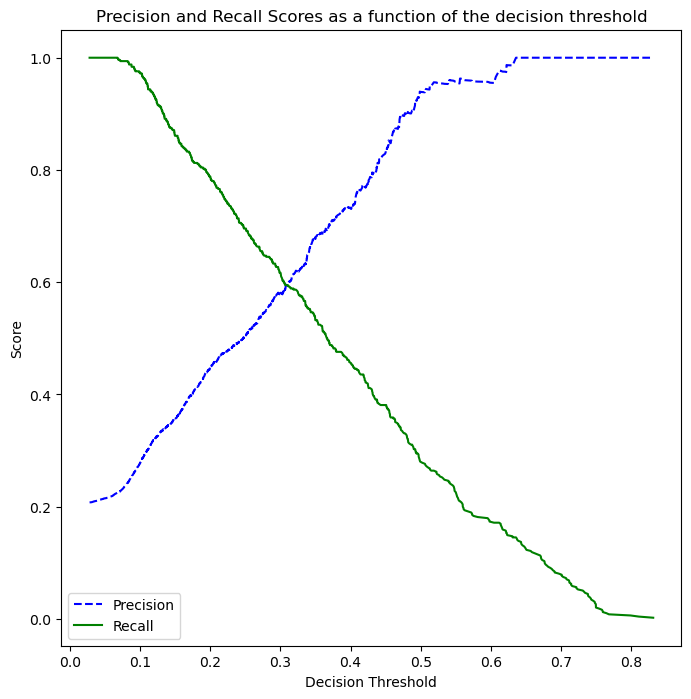

In [51]:
p, r, thresholds = precision_recall_curve(Y_fraudster_controlled, Y_fraudster_controlled_RF_prob[:,1])
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [52]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(Y_fraudster_controlled, Y_fraudster_controlled_RF_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.8513935134720849


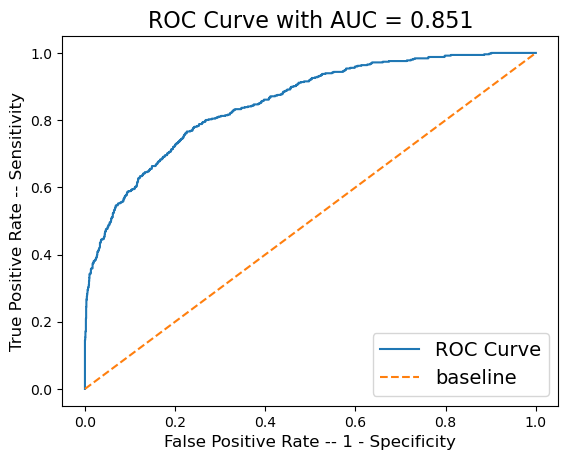

In [53]:
# Plot ROC curve.
plt.plot(fpr, tpr,
         label='ROC Curve')
# Plot baseline.
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes.
plt.title(f"ROC Curve with AUC = {round(roc_auc,3)}", fontsize=16)
plt.xlabel('False Positive Rate -- 1 - Specificity', fontsize=12)
plt.ylabel('True Positive Rate -- Sensitivity', fontsize=12)
# Create legend.
plt.legend(fontsize=14, loc='lower right');

**Confusion Matrix**

In [54]:
# Creating the confusion matrix
MyConfMat = metrics.confusion_matrix(Y_fraudster_controlled, Y_fraudster_controlled_RF)
# Assigning columns names
MyConfMat_df = pd.DataFrame(MyConfMat, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
MyConfMat_df

,Predicted Negative,Predicted Positive
Actual Negative,1693,201
Actual Positive,201,295


In [55]:
confusion_metrics(MyConfMat)

True Positives: 295
True Negatives: 1693
False Positives: 201
False Negatives: 201
--------------------------------------------------
Accuracy: 0.83
Mis-Classification: 0.17
Sensitivity: 0.59
Specificity: 0.89
Precision: 0.89
F_1 Score: 0.71


## XAI <a id='section_4.6'></a>

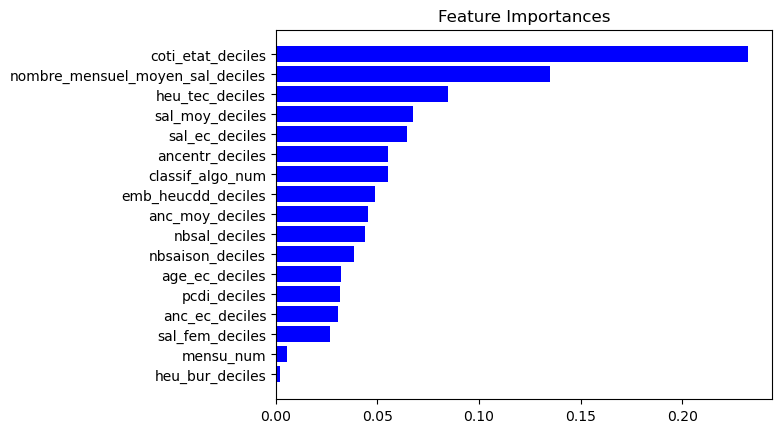

In [56]:
features = X_controlled.columns.tolist()
importances = fraud_clf_RF.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], rotation=0)
# plt.ylabel('Relative Importance')
plt.show()

# Step 2: Projection on the basis of non-controlled customers <a id='section_5'></a>

*[Back to Table of contents](#section_0)*

## Contingency table to analyse controls and fraud rates by sectors on the controlled samples  <a id='section_5.1'></a>

In [57]:
ratio = 'Ratio_masse_tot' # 'Ratio_coti_tot'
my_classif = 'classif_algo' # Variable for the classification, 19 categories
my_classif_names = pd.Index(['Act. diverses et Org. service_dum', 'Conchyliculture_dum',
       'Culture et élevage non spécialisés 0111Z_dum', 'Culture et élevage non spécialisés autres_dum', 'Culture et élevage non spécialisés bovins_dum',
       'Cultures spécialisées 0111Z_dum', 'Cultures spécialisées 0113Z_dum',
       'Cultures spécialisées 0124Z_dum', 'Cultures spécialisées 0130Z_dum',
       'Cultures spécialisées autres_dum', 'Elevage spécialisés gros animaux_dum',
       'Elevage spécialisés petits animaux_dum', 'Entrainement, dressage, haras_dum',
       'Entreprises de travaux agricoles 0161Z_dum', 'Entreprises de travaux agricoles 8130Z_dum',
       'Entreprises de travaux agricoles autres_dum', 'Travaux forestiers activforest_dum', 
       'Travaux forestiers autres_dum', 'Viticulture_dum'])

In [58]:
threshold_value = 0.95
Data_final_for_analysis_annual['Ratio_thres'] = np.where(Data_final_for_analysis_annual[ratio] > np.quantile(Data_final_for_analysis_annual[Data_final_for_analysis_annual[ratio].notna()][ratio], threshold_value), np.nan, Data_final_for_analysis_annual[ratio])

In [59]:
# Created variables are string
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num','Montants']].sum().sort_index()
my_classif_mean = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ratio_thres']].mean().sort_index()
my_classif_output_temp = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True)
my_classif_output_ini = pd.merge(my_classif_output_temp, my_classif_mean, left_index=True, right_index=True, how='left')
# Controls rate
my_classif_output_ini['Ctrl_rate_obs.'] = (my_classif_output_ini['Ctrl_num']/my_classif_output_ini[my_classif])
# Taux de fraude sur les contrôles
my_classif_output_ini['Fraude_rate_obs.'] = (my_classif_output_ini['Fraude_num']/my_classif_output_ini['Ctrl_num'])
# Taux de fraude sur les observations
# my_classif_output_ini['Fraude_rate_all'] = (my_classif_output_ini['Ctrl_num']/my_classif_output_ini[my_classif])
my_classif_output_ini['Montants_moyen_obs.'] = my_classif_output_ini['Montants']/my_classif_output_ini['Fraude_num']
my_classif_output_ini = my_classif_output_ini.fillna(0)
nom = ['Ratio_thres']
my_classif_output_ini.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Ratio_thres":"{:.2%}", "Ctrl_rate_obs.":"{:.2%}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

,classif_algo,Ctrl_num,Fraude_num,Montants,Ratio_thres,Ctrl_rate_obs.,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,502,305.80%,0.33%,40.62%,39
Conchyliculture,1787,97,12,76,271.48%,5.43%,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,596,347.90%,0.48%,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,389,354.20%,0.67%,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,242,338.41%,0.50%,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,156,212.85%,1.98%,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,1206,406.85%,3.23%,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,906,252.82%,5.21%,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,79,151.47%,2.60%,11.48%,11
Cultures spécialisées autres,7781,161,22,833,307.59%,2.07%,13.66%,38


In [60]:
Data_final_for_analysis_annual['Ratio_thres'].mean()

2.9966417082823886

In [61]:
my_classif_output_ini['Fraude_rate_obs.'].mean()

0.24459590413613674

In [62]:
print(my_classif_output_ini['Ctrl_num'].sum())
print(my_classif_output_ini['Fraude_num'].sum())
print(my_classif_output_ini['Montants'].sum())

2390
496
14328


In [63]:
print(my_classif_output_ini[my_classif].sum())

162390


The amount collected on the basis of those inspected is 14338.
The amount predicted on the basis of the controls with the contingency table is 22978.
The RMSE obtained with the regression method is 89.
The R2 of the regression with the contingency table is 10.89%.


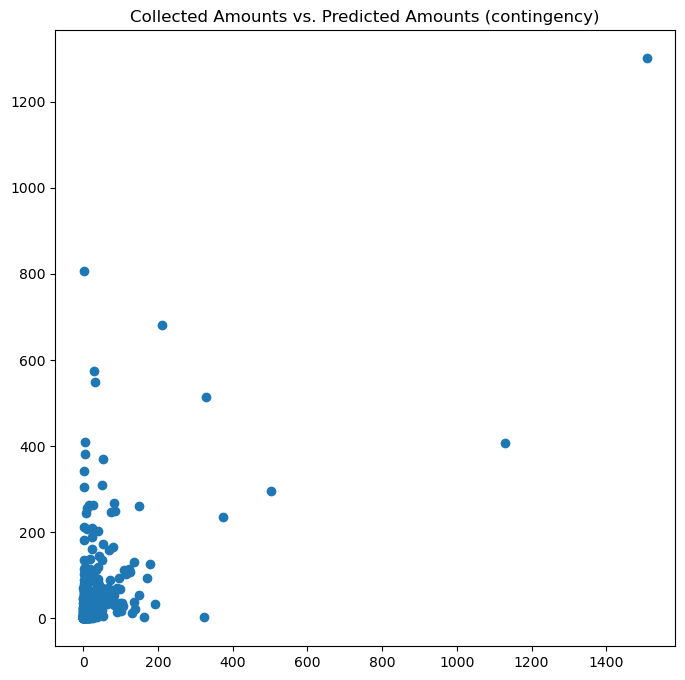

In [64]:
Y_amount_controlled = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Montants'].notna()][[my_classif,'masse_tot','Montants']].reset_index()
Y_amount_controlled = Y_amount_controlled.set_index([my_classif])
my_classif_output_ini_to_merge = my_classif_output_ini['Ratio_thres']
my_classif_output_ini_to_merge.index = my_classif_output_ini[['Ratio_thres']].index.set_names(my_classif)
Y_amount_controlled_contingence = pd.merge(Y_amount_controlled, my_classif_output_ini_to_merge, left_index=True, right_index=True, how="inner")
Y_amount_controlled_contingence = Y_amount_controlled_contingence.reset_index().set_index(['index']).sort_index()
Y_amount_controlled_contingence['pred_contingence'] = Y_amount_controlled_contingence['masse_tot']*Y_amount_controlled_contingence['Ratio_thres']
print(f"The amount collected on the basis of those inspected is {Y_amount_controlled_contingence['Montants'].sum():0.0f}.")
print(f"The amount predicted on the basis of the controls with the contingency table is {Y_amount_controlled_contingence['pred_contingence'].sum():0.0f}.")
# Calculation of Root Mean Squared Error (RMSE)
Y_true = Y_amount_controlled_contingence['Montants']
Y_pred = Y_amount_controlled_contingence['pred_contingence']
print(f"The RMSE obtained with the regression method is {np.sqrt(mean_squared_error(Y_true,Y_pred)):0.0f}.")
print(f"The R2 of the regression with the contingency table is {r2_score(Y_true, Y_pred):0.2%}.")
# Graphique montants prévus vs. montants observés
plt.figure(figsize=(8, 8))
plt.title("Collected Amounts vs. Predicted Amounts (contingency)")
plt.scatter(Y_true, Y_pred)

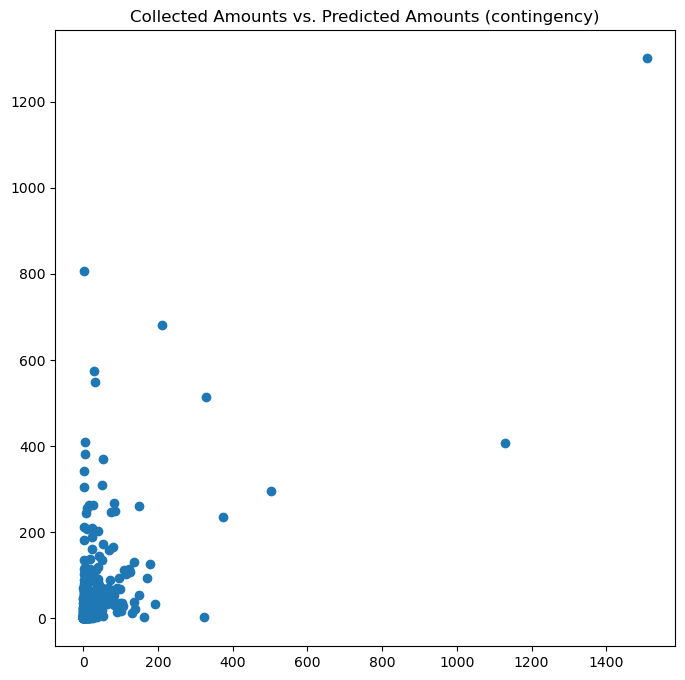

In [65]:
plt.figure(figsize=(8, 8))
plt.title("Collected Amounts vs. Predicted Amounts (contingency)")
plt.scatter(Y_true[Y_true<50000], Y_pred[Y_true<50000])

The amounts predicted with the contingency table are higher than those observed, as the average ratios per class used to multiply the total payroll of each company are on average higher than the individual ratios. As a reminder, it is these individual ratios that are averaged by class.

However, this empirical observation cannot be generalized to the uncontrolled.

## Random forest to explain the amount of fraud on the controlled population <a id='section_5.2'></a>

In [66]:
base_fraudster = base_controlled[base_controlled['Fraude_num'] == 1]
print(base_fraudster.shape)
# We have only 496 observations of fraud
Y_fraud_amount = base_fraudster['Montants']
print(Y_fraud_amount.shape)
X_fraudster = base_fraudster.drop(['Ctrl_num', 'Fraude_num', 'Montants'], axis = 1)
print(X_fraudster.shape)

(496, 20)
(496,)
(496, 17)


In [67]:
# RandomForestRegressor?
# xgb.XGBRegressor?

In [68]:
# Estimation based on a Random Forest
fraud_amount_reg = RandomForestRegressor(n_estimators=500, max_depth=6, max_leaf_nodes=32, random_state=42)
fraud_amount_reg.fit(X_fraudster, Y_fraud_amount)

RandomForestRegressor(max_depth=6, max_leaf_nodes=32, n_estimators=500,
                      random_state=42)

In [69]:
# fraud_amount_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
# fraud_amount_reg.fit(X_fraudster, Y_fraud_amount)

La RMSE obtenue avec la méthode de régression est de 35
La R2 de la régression est de 86.71%.


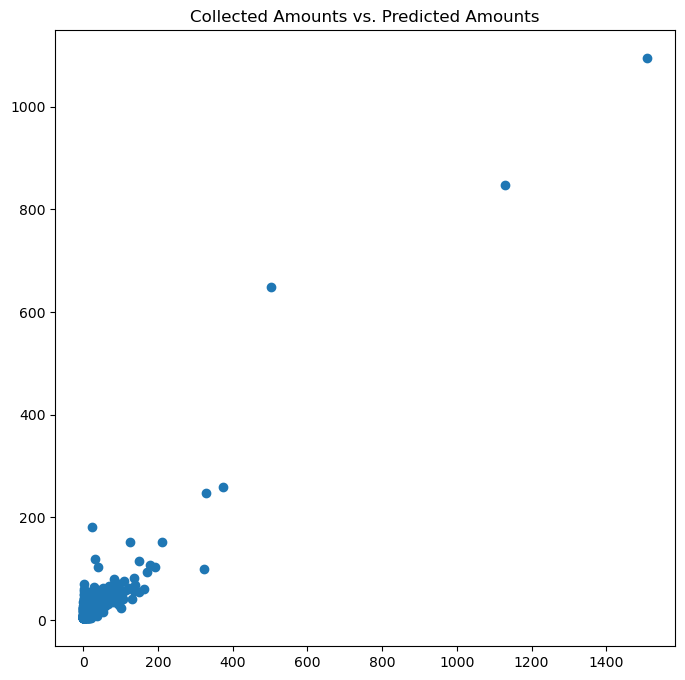

In [70]:
# Calculation of Root Mean Squared Error (RMSE)
Y_true = Y_fraud_amount
Y_pred = fraud_amount_reg.predict(X_fraudster)
print(f"La RMSE obtenue avec la méthode de régression est de {np.sqrt(mean_squared_error(Y_true,Y_pred)):0.0f}")
print(f"La R2 de la régression est de {r2_score(Y_true, Y_pred):0.2%}.")
# Graphique montants prévus vs. montants observés
plt.figure(figsize=(8, 8))
plt.title("Collected Amounts vs. Predicted Amounts")
plt.scatter(Y_true, Y_pred)

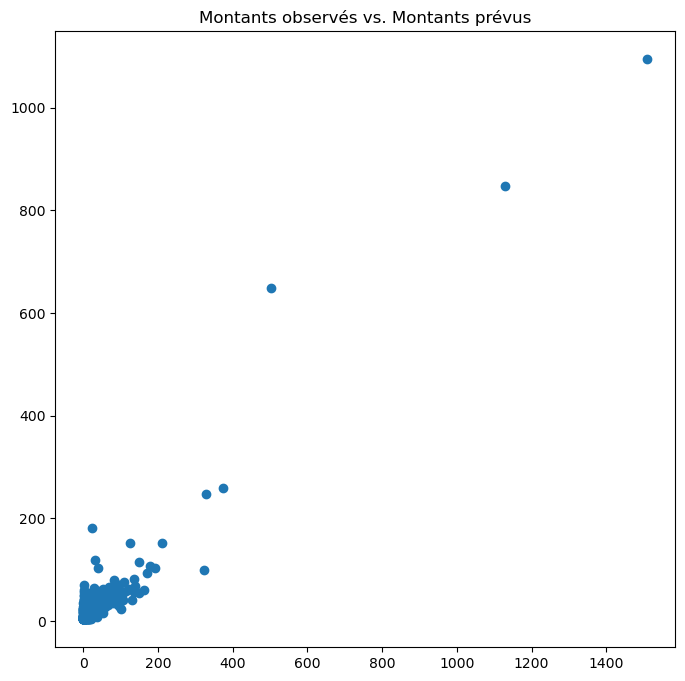

In [71]:
plt.figure(figsize=(8, 8))
plt.title("Montants observés vs. Montants prévus")
plt.scatter(Y_true[Y_true<50000], Y_pred[Y_true<50000])

## XAI <a id='section_5.3'></a>

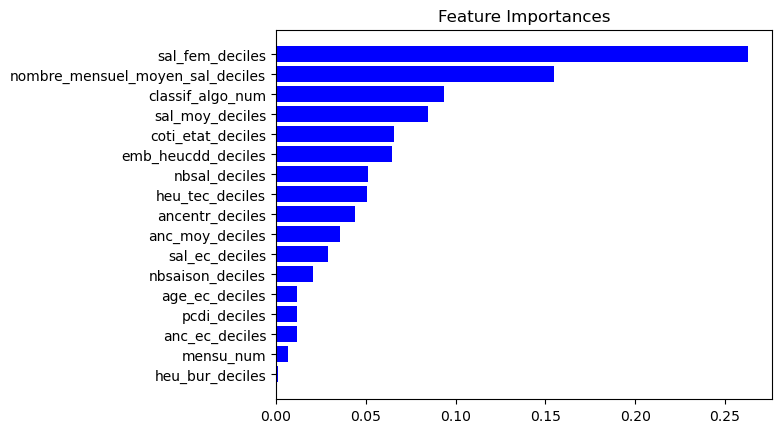

In [72]:
features = X_fraudster.columns.tolist()
importances = fraud_amount_reg.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], rotation=0)
# plt.ylabel('Relative Importance')
plt.show()

## Projection based on uncontrolled with threshold adjustment <a id='section_5.4'></a>

In [73]:
# Nb fraudsters in the "test" database => as expected we cannot check our prediction
Y_fraudster_uncontrolled = base_uncontrolled['Fraude_num']
print(Y_fraudster_uncontrolled.shape)
print(sum(Y_fraudster_uncontrolled))

(160000,)
nan


In [74]:
# Fraudster prediction on the uncontrolled database to determine who could be a fraudster, we predict the class here
Y_fraudster_uncontrolled_RF_prob = fraud_clf_RF.predict_proba(X_uncontrolled)

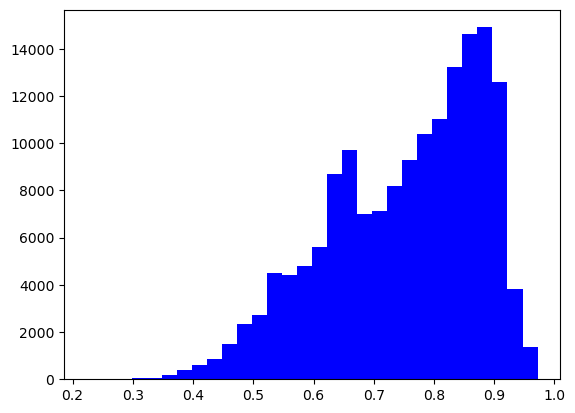

In [75]:
plt.hist(Y_fraudster_uncontrolled_RF_prob[:,0], label ="Prob. = 0", color ="b", bins = 30)
plt.show()

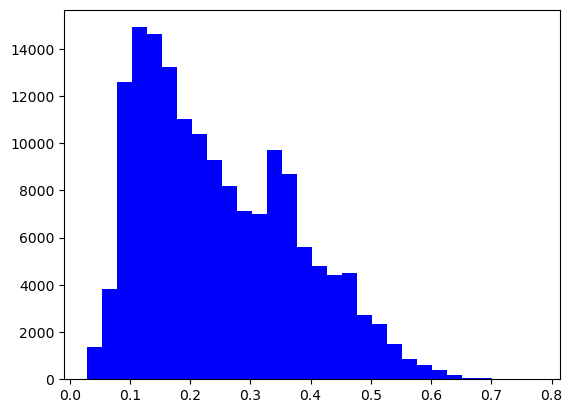

In [76]:
plt.hist(Y_fraudster_uncontrolled_RF_prob[:,1], label ="Prob. = 1", color ="b", bins = 30)
plt.show()

In [77]:
# Optimum threshold recovery
threshold = np.quantile(Y_fraudster_controlled_RF_prob[:, 1], 1-np.mean(base_controlled['Fraude_num']))
Y_fraudster_controlled_RF = (Y_fraudster_controlled_RF_prob[:,1] >= threshold).astype('int')
threshold

0.3078092440851451

In [78]:
Y_fraudster_uncontrolled_RF = (Y_fraudster_uncontrolled_RF_prob[:,1] >= threshold).astype('int')

In [79]:
# We predict 52119 fraudsters corresponding to 32.53% of the uncontrolled database
print(sum(Y_fraudster_uncontrolled_RF))
print(np.mean(Y_fraudster_uncontrolled_RF))

52119
0.32574375


In [80]:
# Recovery of individuals labelled as Fraudsters
Y_fraudster_uncontrolled_RF = pd.DataFrame(Y_fraudster_uncontrolled_RF, index = X_uncontrolled.index, columns = ['Fraude_pred'])

In [81]:
# Recovery of the my_classif variable, but dichotomized into its number of classes, to be used for a matrix product.
Data_modified_uncontrolled = Data_final_modified_annual[Data_final_modified_annual['Fraude_num'].isna()][my_classif_names]
Data_modified_uncontrolled.columns = my_classif_output_ini.index

### Contingency Table

In [82]:
Data_final_for_analysis_uncontrolled = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Fraude_num'].isna()][[my_classif,'masse_tot']]

In [83]:
Data_SISAL_uncontrolled = pd.concat([Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_RF], axis = 1)
# Produit matriciel afin de mettre le bon ratio moyen (contenu dans la colonne 'Ratio_thres') à chaque observation de la base
Data_SISAL_uncontrolled['Ratio_thres_mean'] = Data_modified_uncontrolled.dot(my_classif_output_ini['Ratio_thres'])
# Multiplication éléments par éléments pour obtenir les Montants prédits
Data_SISAL_uncontrolled['Montants_pred'] = Data_SISAL_uncontrolled['Ratio_thres_mean'].multiply(Data_SISAL_uncontrolled['masse_tot']).multiply(Data_SISAL_uncontrolled['Fraude_pred'])
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred','Montants_pred']].sum().sort_index()
# my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The predicted amount of fraud due to hidden work is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():0.0f}.")
print(f"The collected amount of fraud due to hidden work is equal to {Data_final_for_analysis_annual['Montants'].sum():0.0f}.")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

The predicted amount of fraud due to hidden work is equal to 730335.
The collected amount of fraud due to hidden work is equal to 14338.


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,5110,423530,52.52%,83,40.62%,39
Conchyliculture,1787,97,12,671,1820,39.70%,3,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,9326,57866,38.87%,6,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,6196,40653,34.64%,7,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,5489,22628,44.25%,4,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,870,3020,27.93%,3,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,1143,8936,24.93%,8,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,612,3013,17.24%,5,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,380,1808,16.64%,5,11.48%,11
Cultures spécialisées autres,7781,161,22,1746,37249,22.91%,21,13.66%,38


### Regression model

In [84]:
# We keep rows labelled as predicted fraudsters
X_uncontrolled_fraudster = X_uncontrolled[Y_fraudster_uncontrolled_RF['Fraude_pred'] == 1]
print(X_uncontrolled_fraudster.shape)
# Predicted amount of fraud on the uncontrolled sample predicted as fraudster
Y_fraudster_uncontrolled_RF_amount = fraud_amount_reg.predict(X_uncontrolled_fraudster)
print('> The predicted amount of fraud estimated with the regression model is %.0f' % (np.sum(Y_fraudster_uncontrolled_RF_amount)))

(52119, 17)
> The predicted amount of fraud estimated with the regression model is 710729


### Robustness analysis to calculate STaX (one-step calculation)

The idea is to multiply the probability of each individual in the uncontrolled database being identified as a fraudster by the amount predicted by the regression model. This amounts to calculating a conditional expectation. The advantage of this approach is that we don't have to determine a threshold for identifying fraudsters.

In [85]:
# Predicted probability of fraud on the full uncontrolled sample
Y_uncontrolled_RF_prob = fraud_clf_RF.predict_proba(X_uncontrolled)
print(Y_uncontrolled_RF_prob.shape)
# Predicted amount of fraud on the full uncontrolled sample
Y_uncontrolled_RF_amount = fraud_amount_reg.predict(X_uncontrolled)
print(Y_uncontrolled_RF_amount.shape)

(160000, 2)
(160000,)


In [86]:
print(f"The predicted amount of fraud due to hidden work is equal to {Y_uncontrolled_RF_prob[:,1].T.dot(Y_uncontrolled_RF_amount):0.0f}.")
# (Y_uncontrolled_RF_prob[:,1]*Y_uncontrolled_RF_amount).sum()

The predicted amount of fraud due to hidden work is equal to 796032.


## Projection on the basis of non-controlled with a threshold of 0.5 <a id='section_5.5'></a>

**Controlled database**

In [87]:
Y_fraudster_controlled_RF_05 = fraud_clf_RF.predict(X_controlled)

In [88]:
# Creating the confusion matrix
MyConfMat = metrics.confusion_matrix(Y_fraudster_controlled, Y_fraudster_controlled_RF_05)
# Assigning columns names
MyConfMat_df = pd.DataFrame(MyConfMat, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
MyConfMat_df

,Predicted Negative,Predicted Positive
Actual Negative,1885,9
Actual Positive,358,138


In [89]:
confusion_metrics(MyConfMat)

True Positives: 138
True Negatives: 1885
False Positives: 9
False Negatives: 358
--------------------------------------------------
Accuracy: 0.85
Mis-Classification: 0.15
Sensitivity: 0.28
Specificity: 1.0
Precision: 1.0
F_1 Score: 0.43


**Uncontrolled database**

In [90]:
Y_fraudster_uncontrolled_RF_predict = (Y_fraudster_uncontrolled_RF_prob[:,1] >= 0.5).astype('int')
# We predict 7243 fraudsters corresponding to 3.9% of the uncontrolled database
print(sum(Y_fraudster_uncontrolled_RF_predict))
print(np.mean(Y_fraudster_uncontrolled_RF_predict))

6237
0.03898125


In [91]:
# Y_fraudster_uncontrolled_RF_predict_check = fraud_clf.predict(X_uncontrolled)
# print(sum(Y_fraudster_uncontrolled_RF_predict_check))
# print(np.mean(Y_fraudster_uncontrolled_RF_predict_check))

### Contingency table

In [92]:
Y_fraudster_uncontrolled_RF_predict = pd.DataFrame(Y_fraudster_uncontrolled_RF_predict, index = X_uncontrolled.index, columns = ['Fraude_pred'])

In [93]:
Data_SISAL_uncontrolled = pd.concat([Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_RF_predict], axis = 1)
# Produit matriciel afin de mettre le bon ratio moyen (contenu dans la colonne 'Ratio_thres') à chaque observation de la base
Data_SISAL_uncontrolled['Ratio_thres_mean'] = Data_modified_uncontrolled.dot(my_classif_output_ini['Ratio_thres'])
# Multiplication éléments par éléments pour obtenir les Montants prédits
Data_SISAL_uncontrolled['Montants_pred'] = Data_SISAL_uncontrolled['Ratio_thres_mean'].multiply(Data_SISAL_uncontrolled['masse_tot']).multiply(Data_SISAL_uncontrolled['Fraude_pred'])
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred','Montants_pred']].sum().sort_index()
# my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The predicted amount of fraud due to hidden work is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():0.0f}.")
print(f"The collected amount of fraud due to hidden work is equal to {Data_final_for_analysis_annual['Montants'].sum():0.0f}.")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = my_classif_uncontrolled_output.fillna(0)
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

The predicted amount of fraud due to hidden work is equal to 36573.
The collected amount of fraud due to hidden work is equal to 14338.


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,761,5193,7.82%,7,40.62%,39
Conchyliculture,1787,97,12,28,82,1.66%,3,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,535,3887,2.23%,7,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,607,2461,3.39%,4,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,644,1221,5.19%,2,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,146,752,4.69%,5,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,129,1251,2.81%,10,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,80,511,2.25%,6,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,60,312,2.63%,5,11.48%,11
Cultures spécialisées autres,7781,161,22,288,2988,3.78%,10,13.66%,38


### Regression model

In [94]:
# We keep rows labelled as predicted fraudsters
X_uncontrolled_fraudster = X_uncontrolled[Y_fraudster_uncontrolled_RF_predict['Fraude_pred'] == 1]
print(X_uncontrolled_fraudster.shape)
# Predicted amount of fraud on the uncontrolled sample predicted as fraudster
Y_fraudster_uncontrolled_RF_amount = fraud_amount_reg.predict(X_uncontrolled_fraudster)
print('> The predicted amount of fraud due to hidden work estimated with the regression model is %.0f' % (np.sum(Y_fraudster_uncontrolled_RF_amount)))

(6237, 17)
> The predicted amount of fraud due to hidden work estimated with the regression model is 75564


## Projection on the basis of uncontrolled with a sweep over the threshold <a id='section_5.6'></a>

In [95]:
DF_to_plot = []
for threshold in np.arange(0.3,0.51,0.01):
    Y_fraudster_uncontrolled_RF = (Y_fraudster_uncontrolled_RF_prob[:,1] >= threshold).astype('int')
    print(f"> The threshold is equal to {threshold}.")
    print(f"The predicted number of fraudsters is {np.sum(Y_fraudster_uncontrolled_RF)}.")
    print(f"Corresponding to a percentage of fraudsters of {(np.mean(Y_fraudster_uncontrolled_RF,axis=0)):#0.2%}")
    # Récupération des individus labellisés comme Fraudeurs
    Y_fraudster_uncontrolled_RF = pd.DataFrame(Y_fraudster_uncontrolled_RF, index = X_uncontrolled.index, columns = ['Fraude_pred'])
    Data_modified_uncontrolled = Data_final_modified_annual[Data_final_modified_annual['Fraude_num'].isna()][my_classif_names]
    Data_modified_uncontrolled.columns = my_classif_output_ini.index
    Data_final_for_analysis_uncontrolled = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Fraude_num'].isna()][[my_classif,'masse_tot']]
    Data_SISAL_uncontrolled = pd.concat([Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_RF], axis = 1)
    # Produit matriciel afin de mettre le bon ratio moyen (contenu dans la colonne 'Ratio_thres') à chaque observation de la base
    Data_SISAL_uncontrolled['Ratio_thres_mean'] = Data_modified_uncontrolled.dot(my_classif_output_ini['Ratio_thres'])
    # Multiplication éléments par éléments pour obtenir les Montants prédits
    Data_SISAL_uncontrolled['Montants_pred'] = Data_SISAL_uncontrolled['Ratio_thres_mean'].multiply(Data_SISAL_uncontrolled['masse_tot']).multiply(Data_SISAL_uncontrolled['Fraude_pred'])
    print(f"The predicted amount of fraud due to hidden work estimated with the contingency table is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():#0.0f}")
    # We keep rows labelled as predicted fraudsters
    X_uncontrolled_fraudster = X_uncontrolled[Y_fraudster_uncontrolled_RF['Fraude_pred'] == 1]
    # Predicted amount of fraud on the uncontrolled sample predicted as fraudster
    Y_fraudster_uncontrolled_RF_amount = fraud_amount_reg.predict(X_uncontrolled_fraudster)
    print('The predicted amount of fraud due to hidden work estimated with the regression model is %.0f' % (np.sum(Y_fraudster_uncontrolled_RF_amount)))
    row = [threshold, np.sum(Y_fraudster_uncontrolled_RF).values[0], np.mean(Y_fraudster_uncontrolled_RF,axis=0).values[0], Data_SISAL_uncontrolled['Montants_pred'].sum(), np.sum(Y_fraudster_uncontrolled_RF_amount)]
    DF_to_plot.append(row)

DF_to_plot = pd.DataFrame(DF_to_plot, columns = ["threshold", "nb_fraudsters", "percentage_fraudsters", "STaX_table", "STaX_regression"])

> The threshold is equal to 0.3.
The predicted number of fraudsters is 54165.
Corresponding to a percentage of fraudsters of 33.85%
The predicted amount of fraud due to hidden work estimated with the contingency table is equal to 804263.
The predicted amount of fraud due to hidden work estimated with the regression model is 751200
> The threshold is equal to 0.31.
The predicted number of fraudsters is 51486.
Corresponding to a percentage of fraudsters of 32.18%
The predicted amount of fraud due to hidden work estimated with the contingency table is equal to 711158.
The predicted amount of fraud due to hidden work estimated with the regression model is 698263
> The threshold is equal to 0.32.
The predicted number of fraudsters is 48648.
Corresponding to a percentage of fraudsters of 30.40%
The predicted amount of fraud due to hidden work estimated with the contingency table is equal to 641065.
The predicted amount of fraud due to hidden work estimated with the regression model is 648099

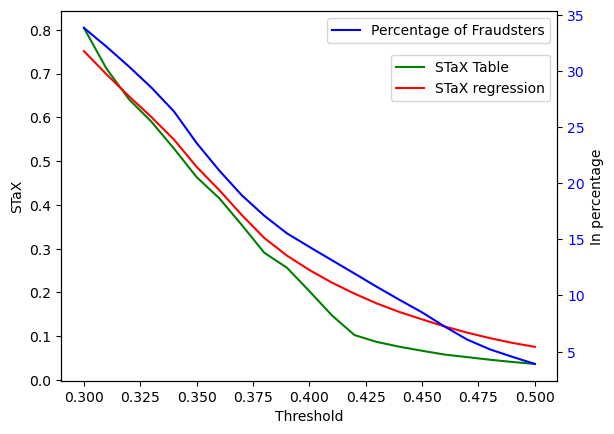

In [96]:
fig, ax = plt.subplots()

ax.plot(DF_to_plot['threshold'], DF_to_plot['STaX_table'].astype(int)/1000000, color = 'green', label = 'STaX Table')
ax.plot(DF_to_plot['threshold'], DF_to_plot['STaX_regression'].astype(int)/1000000, color = 'red', label = 'STaX regression')
ax.legend(loc = 'upper right',bbox_to_anchor=(1, 0.9))

plt.xlabel('Threshold')
plt.ylabel("STaX")

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

ax2.plot(DF_to_plot['threshold'], DF_to_plot['percentage_fraudsters']*100, color='blue', label = 'Percentage of Fraudsters')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc = 'upper right')

plt.ylabel("In percentage")

plt.show()

## Conclusion <a id='section_5.6'></a>

We decide to set the threshold so as to obtain 20% fraudsters in the uncontrolled base.

In [97]:
threshold = 0.36465
print(threshold)
Y_fraudster_uncontrolled_RF = (Y_fraudster_uncontrolled_RF_prob[:,1] >= threshold).astype('int')
# We predict 37063 fraudsters corresponding to 20.00% of the uncontrolled database
print(sum(Y_fraudster_uncontrolled_RF))
print(np.mean(Y_fraudster_uncontrolled_RF))

0.36465
32046
0.2002875


### Contingency table

In [98]:
Y_fraudster_uncontrolled_RF = pd.DataFrame(Y_fraudster_uncontrolled_RF, index = X_uncontrolled.index, columns = ['Fraude_pred'])
Data_SISAL_uncontrolled = pd.concat([Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_RF], axis = 1)
# Produit matriciel afin de mettre le bon ratio moyen (contenu dans la colonne 'Ratio_thres') à chaque observation de la base
Data_SISAL_uncontrolled['Ratio_thres_mean'] = Data_modified_uncontrolled.dot(my_classif_output_ini['Ratio_thres'])
# Multiplication éléments par éléments pour obtenir les Montants prédits
Data_SISAL_uncontrolled['Montants_pred'] = Data_SISAL_uncontrolled['Ratio_thres_mean'].multiply(Data_SISAL_uncontrolled['masse_tot']).multiply(Data_SISAL_uncontrolled['Fraude_pred'])
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred','Montants_pred']].sum().sort_index()
# my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The amount of fraud due to hidden work is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():0.0f}.")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

The amount of fraud due to hidden work is equal to 384097.


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,3839,220596,39.46%,57,40.62%,39
Conchyliculture,1787,97,12,360,893,21.30%,2,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,4945,26730,20.61%,5,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,3360,18967,18.78%,6,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,3219,10544,25.95%,3,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,536,1925,17.21%,4,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,655,5069,14.29%,8,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,363,1853,10.23%,5,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,210,833,9.19%,4,11.48%,11
Cultures spécialisées autres,7781,161,22,1136,18415,14.91%,16,13.66%,38


### Regression model

In [99]:
# We keep rows labelled as predicted fraudsters
X_uncontrolled_fraudster = X_uncontrolled[Y_fraudster_uncontrolled_RF['Fraude_pred'] == 1]
print(X_uncontrolled_fraudster.shape)
# Predicted amount of fraud on the uncontrolled sample predicted as fraudster
Y_fraudster_uncontrolled_RF_amount = fraud_amount_reg.predict(X_uncontrolled_fraudster)
print('> The predicted amount of fraud due to hidden work estimated with the regression model is %.0f' % (np.sum(Y_fraudster_uncontrolled_RF_amount)))

(32046, 17)
> The predicted amount of fraud due to hidden work estimated with the regression model is 405210


**Répartition du montant par classe**

In [100]:
Y_fraudster_uncontrolled_RF_amount = pd.DataFrame(Y_fraudster_uncontrolled_RF_amount, index = X_uncontrolled_fraudster.index, columns = ['Montants_pred'])
Y_fraudster_uncontrolled_RF = pd.merge(Y_fraudster_uncontrolled_RF, Y_fraudster_uncontrolled_RF_amount, left_index=True, right_index=True, how='left')
Data_SISAL_uncontrolled = pd.merge(Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_RF, left_index=True, right_index=True, how='left')
#
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred','Montants_pred']].sum().sort_index()
# my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The predicted amount of fraud due to hidden work is {Data_SISAL_uncontrolled['Montants_pred'].sum():0.0f} and is splitted as follows")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = my_classif_uncontrolled_output.fillna(0)
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

The predicted amount of fraud due to hidden work is 405210 and is splitted as follows


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,3839,74011,39.46%,19,40.62%,39
Conchyliculture,1787,97,12,360,3413,21.30%,9,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,4945,51028,20.61%,10,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,3360,34453,18.78%,10,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,3219,29669,25.95%,9,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,536,5257,17.21%,10,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,655,7415,14.29%,11,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,363,3548,10.23%,10,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,210,2543,9.19%,12,11.48%,11
Cultures spécialisées autres,7781,161,22,1136,15710,14.91%,14,13.66%,38


# Step 3: Semi-supervised approaches <a id='section_6'></a>

*[Back to Table of contents](#section_0)*

## Creation of an alternative classifier for the semi-supervised self-trained approach <a id='section_6.1'></a>

Based on cross-validation, we fine-tune the XGB classifier by adjusting the `learning rate` and `max_depth` in order to approach the performance of the random forest (RF) used previously.

In [101]:
#clf1 = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1)
clf1 = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss",
                         random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1)
clf2 = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=6)
my_cross_val_predict_2clf(clf1, clf2, X_controlled, Y_fraudster_controlled)

Fold 0:
Fraud rate in the training set. 0.20711297071129708:
  Sensibility Clf1 Train./Val. : =(0.6237373737373737, 0.43)
  Sensibility Clf2 Train./Val. : =(0.6186868686868687, 0.48)
Fold 1:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.6196473551637279, 0.5252525252525253)
  Sensibility Clf2 Train./Val. : =(0.6246851385390428, 0.5050505050505051)
Fold 2:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.6020151133501259, 0.5353535353535354)
  Sensibility Clf2 Train./Val. : =(0.6045340050377834, 0.5252525252525253)
Fold 3:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.6146095717884131, 0.5050505050505051)
  Sensibility Clf2 Train./Val. : =(0.6221662468513854, 0.5252525252525253)
Fold 4:
Fraud rate in the training set. 0.20763598326359833:
  Sensibility Clf1 Train./Val. : =(0.6146095717884131, 0.47474747474747475)
  Sensibility Clf2 Train./Val. : =(0.6272040302

[[0.6149237971656107, 0.4940808080808082],
 [0.6194552578683561, 0.5020606060606061]]

We obtain the same performance in terms of sensitivity on the basis of training and validation.

We estimate both models on the basis of the controlled ones in order to compare the predicted densities on the basis of the uncontrolled ones.

In [102]:
fraud_clf_XGB = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss",
                         random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1)
fraud_clf_XGB.fit(X_controlled, Y_fraudster_controlled)
# Predicted fraudsters on the uncontrolled database to determine who could be a fraudster, we predict the class here
Y_fraudster_uncontrolled_XGB_prob = fraud_clf_XGB.predict_proba(X_uncontrolled)

fraud_clf_RF = RandomForestClassifier(n_estimators=500, max_depth = 6, random_state=42)
fraud_clf_RF.fit(X_controlled, Y_fraudster_controlled)
# Predicted fraudsters on the uncontrolled database to determine who could be a fraudster, we predict the class here
Y_fraudster_uncontrolled_RF_prob = fraud_clf_RF.predict_proba(X_uncontrolled)

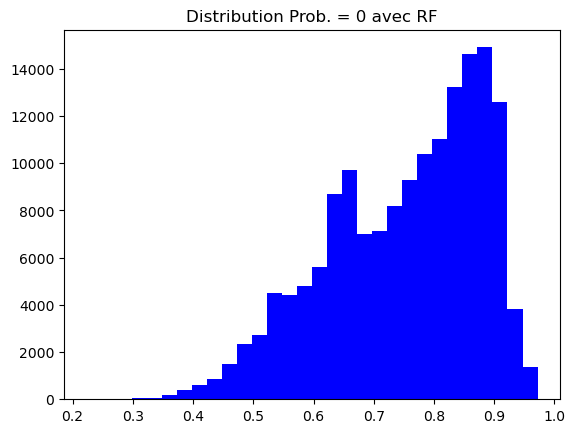

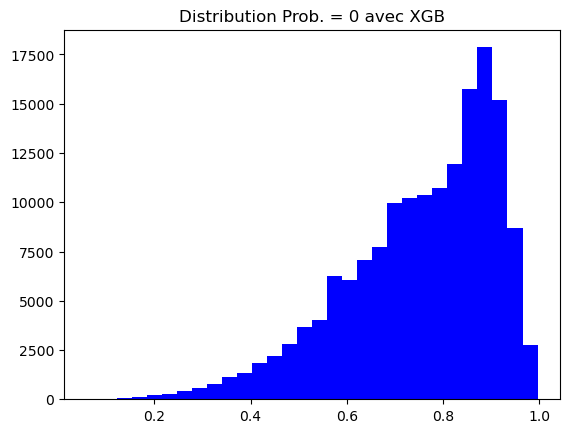

In [103]:
plt.hist(Y_fraudster_uncontrolled_RF_prob[:,0], label ="Prob. = 0", color ="b", bins = 30)
plt.title('Distribution Prob. = 0 avec RF')
plt.show()
plt.hist(Y_fraudster_uncontrolled_XGB_prob[:,0], label ="Prob. = 0", color ="b", bins = 30)
plt.title('Distribution Prob. = 0 avec XGB')
plt.show()

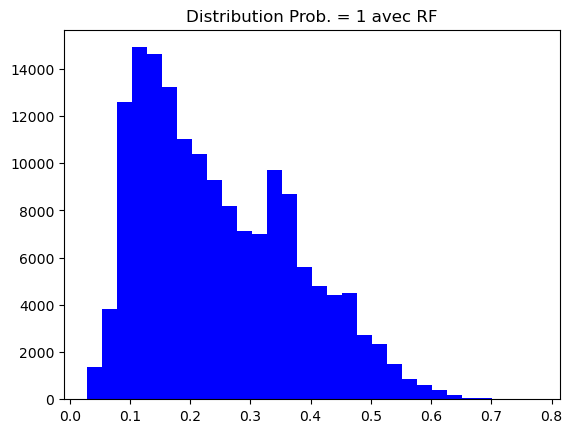

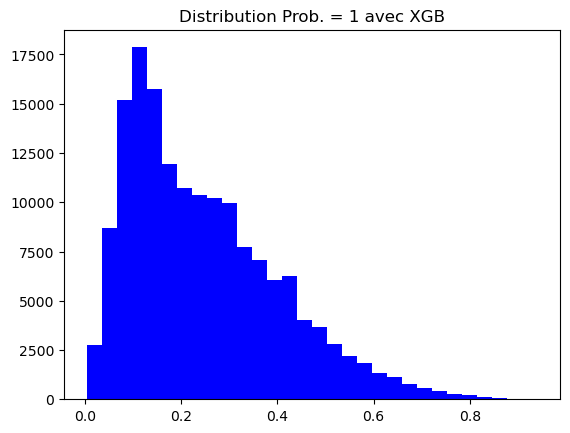

In [104]:
plt.hist(Y_fraudster_uncontrolled_RF_prob[:,1], label ="Prob. = 1", color ="b", bins = 30)
plt.title('Distribution Prob. = 1 avec RF')
plt.show()
plt.hist(Y_fraudster_uncontrolled_XGB_prob[:,1], label ="Prob. = 1", color ="b", bins = 30)
plt.title('Distribution Prob. = 1 avec XGB')
plt.show()

**The advantage of this is that XGBoost's probability distribution is more stretched to the right, which is interesting for the 1 (identification of fraudsters) because the threshold for pseudo-labeling uncontrolled companies is 75% by default in the self-training classifier.**

## Self-training Classifier <a id='section_6.2'></a>

In [105]:
X_ss = Data_appa.drop(['Ctrl_num','Fraude_num','Montants'], axis = 1)
# Modalities from Y to label are coded by -1
Y_ss = Data_appa['Fraude_num'].fillna(-1)

In [106]:
Y_ss.shape

(162390,)

## With a Random Forest

In [107]:
# The base classifier for self-training
fraud_clf_ss = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=42)
self_train_clf = SelfTrainingClassifier(fraud_clf_ss, threshold=0.75).fit(X_ss, Y_ss)

The labels used for the final fit of the classifier, including pseudo-labels added during fit.

In [108]:
np.unique(self_train_clf.transduction_)

array([0., 1.])

In [109]:
# Nb of "unique" fraudsters over the year
print(f"The number of fraudsters in the labelled-data is {Data_Y_annual['Fraude_num'].sum():#0.0f}")
# Now we're on to the predicted (labeled and pseudo-labeled)
print(f"The number of companies labelled as fraudsters is {sum(self_train_clf.transduction_[(Y_ss == -1)] == 1)}.") 
print(f"The number of companies labelled as non-fraudulent is {sum(self_train_clf.transduction_ == 0)}.")
print(f"The number of non-pseudo-labeled companies is {sum(self_train_clf.transduction_ == -1)}.")
print(f"The number of companies to be labeled is indeed {sum(self_train_clf.transduction_ == 1) + sum(self_train_clf.transduction_ == 0) + sum(self_train_clf.transduction_ == -1)}.")

The number of fraudsters in the labelled-data is 496.
The number of companies labelled as fraudsters is 48.
The number of companies labelled as non-fraudulent is 161846.
The number of non-pseudo-labeled companies is 0.
The number of companies to be labeled is indeed 162390.


The number of rounds of self-training, that is the number of times the base estimator is fitted on relabeled variants of the training set.

In [110]:
self_train_clf.n_iter_

9

The reason that fitting was stopped.

In [111]:
self_train_clf.termination_condition_

'all_labeled'

Names of features seen during fit.

In [112]:
self_train_clf.feature_names_in_

array(['mensu_num', 'classif_algo_num', 'ancentr_deciles', 'pcdi_deciles',
       'age_ec_deciles', 'anc_moy_deciles', 'anc_ec_deciles',
       'sal_moy_deciles', 'sal_ec_deciles', 'heu_tec_deciles',
       'heu_bur_deciles', 'sal_fem_deciles', 'coti_etat_deciles',
       'nombre_mensuel_moyen_sal_deciles', 'nbsaison_deciles',
       'emb_heucdd_deciles', 'nbsal_deciles'], dtype=object)

**We exploit the results on pseudo-labeled data. Thus, we recover the individuals pseudo-labelled with a 1 (i.e. as a fraudster) in order to calculate an amount of loss of earnings.**

### Contingency table

In [113]:
# Fraudsters prediction on the uncontrolled database to determine who could be a fraudster, we predict the class here
Y_fraudster_uncontrolled_RF_ss = pd.DataFrame((self_train_clf.transduction_[(Y_ss == -1)]==1).astype('int'), index = X_ss[(Y_ss == -1)].index, columns = ['Fraude_pred'])
print(f"We have {sum(Y_fraudster_uncontrolled_RF_ss['Fraude_pred'])} fraudsters identified by pseudo-labels,")
print(f"corresponding to a fraud rate of {np.mean(Y_fraudster_uncontrolled_RF_ss['Fraude_pred']):#0.2%}")
Data_SISAL_uncontrolled = pd.concat([Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_RF_ss], axis = 1)
# Produit matriciel afin de mettre le bon ratio moyen (contenu dans la colonne 'Ratio_thres') à chaque observation de la base
Data_SISAL_uncontrolled['Ratio_thres_mean'] = Data_modified_uncontrolled.dot(my_classif_output_ini['Ratio_thres'])
# Multiplication éléments par éléments pour obtenir les Montants prédits
Data_SISAL_uncontrolled['Montants_pred'] = Data_SISAL_uncontrolled['Ratio_thres_mean'].multiply(Data_SISAL_uncontrolled['masse_tot']).multiply(Data_SISAL_uncontrolled['Fraude_pred'])
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred','Montants_pred']].sum().sort_index()
# my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The predicted amount of fraud due to hidden work estimated with the contingency table is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():0.0f}.")
print(f"The collected amount of fraud due to hidden work is equal to {Data_final_for_analysis_annual['Montants'].sum():0.0f}.")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = my_classif_uncontrolled_output.fillna(0)
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

We have 48 fraudsters identified by pseudo-labels,
corresponding to a fraud rate of 0.03%
The predicted amount of fraud due to hidden work estimated with the contingency table is equal to 1087.
The collected amount of fraud due to hidden work is equal to 14338.


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,0,0,0.00%,0,40.62%,39
Conchyliculture,1787,97,12,0,0,0.00%,0,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,0,0,0.00%,0,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,2,28,0.01%,14,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,5,59,0.04%,12,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,0,0,0.00%,0,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,3,54,0.07%,18,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,2,20,0.06%,10,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,0,0,0.00%,0,11.48%,11
Cultures spécialisées autres,7781,161,22,3,25,0.04%,8,13.66%,38


### Regression model

In [114]:
# We keep rows labelled as predicted fraudsters
X_uncontrolled_fraudster = X_uncontrolled[Y_fraudster_uncontrolled_RF_ss['Fraude_pred'] == 1]
print(X_uncontrolled_fraudster.shape)
# Predicted amount of fraud on the uncontrolled sample predicted as fraudster
Y_fraudster_uncontrolled_RF_ss_amount = fraud_amount_reg.predict(X_uncontrolled_fraudster)
print('> The predicted amount of fraud due to hidden work estimed with the regression model is %.0f' % (np.sum(Y_fraudster_uncontrolled_RF_ss_amount)))

(48, 17)
> The predicted amount of fraud due to hidden work estimed with the regression model is 1202


## With XGBoost

The 0.75 threshold remains unchanged. With `max_iter` at 10, we reach the max_iter, which doesn't allow us to label everyone. The same applies with `max_iter` at 15, but we reduce the number of unlabeled data (to less than 1000).

In [115]:
# The base classifier for self-training
fraud_clf_ss = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss",
                         random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1)
self_train_clf = SelfTrainingClassifier(fraud_clf_ss, threshold=0.75, max_iter=10).fit(X_ss, Y_ss)

In [116]:
# Nb of "unique" fraud over the year
print(f"The number of fraudsters in the labelled data is {Data_Y_annual['Fraude_num'].sum():0.0f}.")
# Now we're on to the predicted (labeled and pseudo-labeled)
print(f"The number of companies labelled as fraudsters is {sum(self_train_clf.transduction_[(Y_ss == -1)] == 1)}.") 
print(f"The number of companies labelled as non-fraudulent is {sum(self_train_clf.transduction_ == 0)}.")
print(f"The number of non-pseudo-labeled companies is {sum(self_train_clf.transduction_ == -1)}.")
print(f"The number of companies to be labeled is indeed {sum(self_train_clf.transduction_ == 1) + sum(self_train_clf.transduction_ == 0) + sum(self_train_clf.transduction_ == -1)}.")

The number of fraudsters in the labelled data is 496.
The number of companies labelled as fraudsters is 15031.
The number of companies labelled as non-fraudulent is 145265.
The number of non-pseudo-labeled companies is 1598.
The number of companies to be labeled is indeed 162390.


The reason that fitting was stopped.

In [117]:
self_train_clf.termination_condition_

'max_iter'

### Contingency table

In [118]:
# Fraudsters prediction on the uncontrolled database to determine who could be a fraudster, we predict the class here
Y_fraudster_uncontrolled_XGB_ss = pd.DataFrame((self_train_clf.transduction_[(Y_ss == -1)]==1).astype('int'), index = X_ss[(Y_ss == -1)].index, columns = ['Fraude_pred'])
# We label 17421 fraudsters among the uncontrolled corresponding to 9.4% of the uncontrolled database
print(f"We have {sum(Y_fraudster_uncontrolled_XGB_ss['Fraude_pred'])} fraudsters identified by our pseudo-labels,")
print(f"corresponding to a fraud rate of {np.mean(Y_fraudster_uncontrolled_XGB_ss['Fraude_pred']):#0.2%}")
Data_SISAL_uncontrolled = pd.concat([Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_XGB_ss], axis = 1)
# Produit matriciel afin de mettre le bon ratio moyen (contenu dans la colonne 'Ratio_thres') à chaque observation de la base
Data_SISAL_uncontrolled['Ratio_thres_mean'] = Data_modified_uncontrolled.dot(my_classif_output_ini['Ratio_thres'])
# Multiplication éléments par éléments pour obtenir les Montants prédits
Data_SISAL_uncontrolled['Montants_pred'] = Data_SISAL_uncontrolled['Ratio_thres_mean'].multiply(Data_SISAL_uncontrolled['masse_tot']).multiply(Data_SISAL_uncontrolled['Fraude_pred'])
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred','Montants_pred']].sum().sort_index()
# my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The predicted amount of fraud due to hidden work estimated with the contingency table is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():#0.0f}")
print(f"The collected amount of fraud due to hidden work is equal to {Data_final_for_analysis_annual['Montants'].sum():#0.0f}")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = my_classif_uncontrolled_output.fillna(0)
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

We have 15031 fraudsters identified by our pseudo-labels,
corresponding to a fraud rate of 9.39%
The predicted amount of fraud due to hidden work estimated with the contingency table is equal to 187363.
The collected amount of fraud due to hidden work is equal to 14338.


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,2407,125861,24.74%,52,40.62%,39
Conchyliculture,1787,97,12,203,251,12.01%,1,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,2254,8856,9.40%,4,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,1541,7615,8.62%,5,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,1308,2170,10.54%,2,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,256,858,8.22%,3,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,273,2052,5.96%,8,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,165,856,4.65%,5,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,87,213,3.81%,2,11.48%,11
Cultures spécialisées autres,7781,161,22,499,7774,6.55%,16,13.66%,38


## Regression model

In [119]:
# We keep rows labelled as predicted fraudsters
X_uncontrolled_fraudster = X_uncontrolled[Y_fraudster_uncontrolled_XGB_ss['Fraude_pred'] == 1]
print(X_uncontrolled_fraudster.shape)
# Predicted amount of fraud on the uncontrolled sample predicted as fraudster
Y_fraudster_uncontrolled_XGB_ss_amount = fraud_amount_reg.predict(X_uncontrolled_fraudster)
print('> The predicted amount of fraud due to hidden work estimated with the regression model is equal to %.0f' % (np.sum(Y_fraudster_uncontrolled_XGB_ss_amount)))

(15031, 17)
> The predicted amount of fraud due to hidden work estimated with the regression model is equal to 166799


**Split of the amount by categories**

In [120]:
Y_fraudster_uncontrolled_XGB_ss_amount = pd.DataFrame(Y_fraudster_uncontrolled_XGB_ss_amount, index = X_uncontrolled_fraudster.index, columns = ['Montants_pred'])
Y_fraudster_uncontrolled_XGB = pd.merge(Y_fraudster_uncontrolled_XGB_ss, Y_fraudster_uncontrolled_XGB_ss_amount, left_index=True, right_index=True, how='left')
Data_SISAL_uncontrolled = pd.merge(Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_XGB, left_index=True, right_index=True, how='left')
#
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred','Montants_pred']].sum().sort_index()
# my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The predicted amount of fraud due to hidden work estimated with the regression model is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():0.0f} and is splitted as follows")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = my_classif_uncontrolled_output.fillna(0)
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

The predicted amount of fraud due to hidden work estimated with the regression model is equal to 166799 and is splitted as follows


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,2407,47709,24.74%,20,40.62%,39
Conchyliculture,1787,97,12,203,1865,12.01%,9,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,2254,17604,9.40%,8,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,1541,12537,8.62%,8,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,1308,7256,10.54%,6,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,256,1924,8.22%,8,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,273,2608,5.96%,10,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,165,1458,4.65%,9,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,87,814,3.81%,9,11.48%,11
Cultures spécialisées autres,7781,161,22,499,6214,6.55%,12,13.66%,38


## Label Spreading <a id='section_6.3'></a>

**Step 1: Separation of labelled and non-labelled data**

We keep only the 10 most important explanatory variables in the explanatory variables, so as not to be influenced by less important variables

In [121]:
base_controlled = Data_appa[Data_appa['Ctrl_num'].notna()]
base_controlled = base_controlled.drop(['mensu_num','pcdi_deciles','age_ec_deciles','anc_ec_deciles','heu_bur_deciles',
                                       'sal_fem_deciles','nbsaison_deciles'], axis = 1)
XY_ss_labelled = base_controlled.drop(['Ctrl_num','Montants'], axis = 1)
print(XY_ss_labelled.shape)
print(XY_ss_labelled['Fraude_num'].unique())

base_uncontrolled = Data_appa[Data_appa['Ctrl_num'].isna()]
base_uncontrolled = base_uncontrolled.drop(['mensu_num','pcdi_deciles','age_ec_deciles','anc_ec_deciles','heu_bur_deciles',
                                       'sal_fem_deciles','nbsaison_deciles'], axis = 1)
XY_ss_unlabelled = base_uncontrolled.drop(['Ctrl_num','Montants'], axis = 1)
# Les Y à labelliser sont notés -1
XY_ss_unlabelled = XY_ss_unlabelled.fillna({'Fraude_num':-1})
print(XY_ss_unlabelled.shape)
print(XY_ss_unlabelled['Fraude_num'].unique())

(2390, 11)
[1. 0.]
(160000, 11)
[-1.]


**Step 2: Define different sub-sets of unlabeled data**.

In [122]:
# Nb of subsets
nb_subsets = 19

# Calculate the subset size
subset_size = len(XY_ss_unlabelled) // nb_subsets

# Generate a random permutation of row indices
indices = np.random.RandomState(seed=42).permutation(len(XY_ss_unlabelled))

# Create a list to store the subsets
subsets = []

# Split the indices into 19 subsets
for i in range(0, len(indices), subset_size):
    subset_indices = indices[i:i+subset_size]
    print(subset_indices.shape)
    # Use the subset indices to select rows from the DataFrame
    subset = XY_ss_unlabelled.iloc[subset_indices]
    # Append the subset to the list
    subsets.append(subset)
    # The 'subsets' list now contains nb_subsets subsets of equal size  plus one with the remaining data from the original DataFrame

(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(8421,)
(1,)


**Step 3: Setting up the label spreading**

This model is similar to the `Label Propagation` algorithm, but uses an affinity matrix based on the Laplacian normalized graph, and a soft tightening on labels (i.e. labels are allowed to change label). The kernel used in this semi-supervised method is the radial basis function or k-nearest neighbor method.

We cross-validate this technique to study its sensitivity to the number of neighbors.

In [123]:
temp_a = my_cross_val_predict_knn(LabelSpreading(kernel='knn', n_neighbors=3, alpha = 0.2), X_controlled, Y_fraudster_controlled)
temp_b = my_cross_val_predict_knn(LabelSpreading(kernel='knn', n_neighbors=7, alpha = 0.2), X_controlled, Y_fraudster_controlled)
temp_c = my_cross_val_predict_knn(LabelSpreading(kernel='knn', n_neighbors=11, alpha = 0.2), X_controlled, Y_fraudster_controlled)
temp_d = my_cross_val_predict_knn(LabelSpreading(kernel='knn', n_neighbors=15, alpha = 0.2), X_controlled, Y_fraudster_controlled)
print(temp_a)
print(temp_b)
print(temp_c)
print(temp_d)

The number of pseudo-labelled fraudsters in the validation sample is 72
The number of pseudo-labelled non-fraudsters in the validation sample is 406
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 1
  Sensibility Train./Val. : =(1.0, 0.32)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 76
The number of pseudo-labelled non-fraudsters in the validation sample is 402
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 2
  Sensibility Train./Val. : =(1.0, 0.2727272727272727)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 81
The number of pseudo-labelled non-fraudsters in the validation sample is 397
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 3
  Sensibility Train./Val. : =(1.0, 0.32323232323232326)
The number of pseudo-labelled fraudsters in the validation sample is 84
The number of pseudo-labelled non-fraudsters in the validation sample is 394
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 4
  Sensibility Train./Val. : =(1.0, 0.31313131313131315)
The number of pseudo-labelled fraudsters in the validation sample is 88
The number of pseudo-labelled non-fraudsters in the validation sample is 390
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 5
  Sensibility Train./Val. : =(1.0, 0.3333333333333333)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 39
The number of pseudo-labelled non-fraudsters in the validation sample is 439
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 1
  Sensibility Train./Val. : =(1.0, 0.19)
The number of pseudo-labelled fraudsters in the validation sample is 39
The number of pseudo-labelled non-fraudsters in the validation sample is 439
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 2
  Sensibility Train./Val. : =(1.0, 0.1717171717171717)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 34
The number of pseudo-labelled non-fraudsters in the validation sample is 444
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 3
  Sensibility Train./Val. : =(1.0, 0.16161616161616163)
The number of pseudo-labelled fraudsters in the validation sample is 47
The number of pseudo-labelled non-fraudsters in the validation sample is 431
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 4
  Sensibility Train./Val. : =(1.0, 0.23232323232323232)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 45
The number of pseudo-labelled non-fraudsters in the validation sample is 433
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 5
  Sensibility Train./Val. : =(1.0, 0.1919191919191919)
The number of pseudo-labelled fraudsters in the validation sample is 31
The number of pseudo-labelled non-fraudsters in the validation sample is 447
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 1
  Sensibility Train./Val. : =(1.0, 0.2)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 34
The number of pseudo-labelled non-fraudsters in the validation sample is 444
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 2
  Sensibility Train./Val. : =(1.0, 0.1414141414141414)
The number of pseudo-labelled fraudsters in the validation sample is 13
The number of pseudo-labelled non-fraudsters in the validation sample is 465
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 3
  Sensibility Train./Val. : =(1.0, 0.08080808080808081)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 32
The number of pseudo-labelled non-fraudsters in the validation sample is 446
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 4
  Sensibility Train./Val. : =(1.0, 0.15151515151515152)
The number of pseudo-labelled fraudsters in the validation sample is 33
The number of pseudo-labelled non-fraudsters in the validation sample is 445
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 5
  Sensibility Train./Val. : =(1.0, 0.1111111111111111)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 24
The number of pseudo-labelled non-fraudsters in the validation sample is 454
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 1
  Sensibility Train./Val. : =(0.9974747474747475, 0.15)
The number of pseudo-labelled fraudsters in the validation sample is 26
The number of pseudo-labelled non-fraudsters in the validation sample is 452
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 2
  Sensibility Train./Val. : =(1.0, 0.10101010101010101)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 14
The number of pseudo-labelled non-fraudsters in the validation sample is 464
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 3
  Sensibility Train./Val. : =(0.9974811083123426, 0.09090909090909091)
The number of pseudo-labelled fraudsters in the validation sample is 25
The number of pseudo-labelled non-fraudsters in the validation sample is 453
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 4
  Sensibility Train./Val. : =(0.9974811083123426, 0.1414141414141414)


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()
C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2218879050.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = XY_ss_unlabelled.append(XY_ss_labelled).sort_index()


The number of pseudo-labelled fraudsters in the validation sample is 25
The number of pseudo-labelled non-fraudsters in the validation sample is 453
The number of non-pseudo-labeled in the validation sample is 0
Label spreading done on fold number 5
  Sensibility Train./Val. : =(0.9974811083123426, 0.13131313131313133)
[1.0, 0.3124848484848485]
[1.0, 0.18951515151515153]
[1.0, 0.13696969696969696]
[0.9979836144823551, 0.12292929292929293]


With a very high alpha (0.6), we see label changes in the learning base.

In [124]:
label_spread_model = LabelSpreading(kernel='knn', n_neighbors=7, alpha = 0.2)

Y_fraudster_uncontrolled_spread_ss = pd.DataFrame(columns = ['Fraude_pred'])
for i, subset in enumerate(subsets):
    print(f'Subset {i+1}:')
    XY_spread = subset.append(XY_ss_labelled).sort_index()
    label_spread_clf = label_spread_model.fit(XY_spread.drop(['Fraude_num'], axis = 1), XY_spread['Fraude_num'])
    # Fraudsters prediction on the uncontrolled database to determine who could be a fraudster, we predict the class here by looking at the pseudo labels
    Y_fraudster_uncontrolled_spread_ss_subset = pd.DataFrame((label_spread_clf.transduction_[(XY_spread['Fraude_num'] == -1)]==1).astype('int'), index = XY_spread[(XY_spread['Fraude_num'] == -1)].index, columns = ['Fraude_pred'])
    Y_fraudster_uncontrolled_spread_ss = pd.concat([Y_fraudster_uncontrolled_spread_ss,Y_fraudster_uncontrolled_spread_ss_subset])
    print(f"The number of unlabeled instance in this subset is equal to {np.sum(label_spread_clf.transduction_[(XY_spread['Fraude_num'] == -1)]== -1).astype('int')}")
    print(f'Label spreading done on subset {i+1}')
    
Y_fraudster_uncontrolled_spread_ss = Y_fraudster_uncontrolled_spread_ss.sort_index()

Subset 1:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 1
Subset 2:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 2
Subset 3:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 3
Subset 4:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 4
Subset 5:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 5
Subset 6:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 6
Subset 7:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 7
Subset 8:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 8
Subset 9:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 9
Subset 10:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 10
Subset 11:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 11
Subset 12:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 12
Subset 13:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 13
Subset 14:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 14
Subset 15:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 15
Subset 16:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 16
Subset 17:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 17
Subset 18:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 18
Subset 19:


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 19
Subset 20:
The number of unlabeled instance in this subset is equal to 0
Label spreading done on subset 20


C:\Users\sbenoit\AppData\Local\Temp\ipykernel_23208\2293971456.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  XY_spread = subset.append(XY_ss_labelled).sort_index()


In [125]:
# No more difference in the number of observations, so it's ok.
print(XY_ss_unlabelled.shape)
print(Y_fraudster_uncontrolled_spread_ss.shape)

(160000, 11)
(160000, 1)


### Contingency table

In [126]:
# We label 33353 fraudsters among the uncontrolled corresponding to 18.00% of the uncontrolled database
print(f"We have {sum(Y_fraudster_uncontrolled_spread_ss['Fraude_pred'])} fraudeurs identifiés avec nos pseudo-labels,")
print(f"corresponding to a fraud rate of {np.mean(Y_fraudster_uncontrolled_spread_ss['Fraude_pred']):#0.2%}")
Data_SISAL_uncontrolled = pd.concat([Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_spread_ss], axis = 1)
# Produit matriciel afin de mettre le bon ratio moyen (contenu dans la colonne 'Ratio_thres') à chaque observation de la base
Data_SISAL_uncontrolled['Ratio_thres_mean'] = Data_modified_uncontrolled.dot(my_classif_output_ini['Ratio_thres'])
# Multiplication éléments par éléments pour obtenir les Montants prédits
Data_SISAL_uncontrolled['Montants_pred'] = Data_SISAL_uncontrolled['Ratio_thres_mean'].multiply(Data_SISAL_uncontrolled['masse_tot']).multiply(Data_SISAL_uncontrolled['Fraude_pred'])
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred','Montants_pred']].sum().sort_index()
# my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The predicted amount of fraud due to hidden work estimated with the contingency table is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():#0.0f}")
print(f"The collected amount of fraud due to hidden work is equal to {Data_final_for_analysis_annual['Montants'].sum():#0.0f}")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = my_classif_uncontrolled_output.fillna(0)
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

We have 28892 fraudeurs identifiés avec nos pseudo-labels,
corresponding to a fraud rate of 18.06%
The predicted amount of fraud due to hidden work estimated with the contingency table is equal to 838327.
The collected amount of fraud due to hidden work is equal to 14338.


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,2855,465385,29.34%,163,40.62%,39
Conchyliculture,1787,97,12,308,5320,18.22%,17,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,4594,54573,19.15%,12,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,3682,53387,20.58%,14,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,2951,21928,23.79%,7,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,422,3594,13.55%,9,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,538,12703,11.74%,24,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,334,4064,9.41%,12,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,241,2042,10.55%,8,11.48%,11
Cultures spécialisées autres,7781,161,22,963,16715,12.64%,17,13.66%,38


### Regression model

In [127]:
# We keep rows labelled as predicted fraudsters
X_uncontrolled_fraudster = X_uncontrolled[Y_fraudster_uncontrolled_spread_ss['Fraude_pred'] == 1]
print(X_uncontrolled_fraudster.shape)
# Predicted amount of fraud on the uncontrolled sample predicted as fraudster
Y_fraudster_uncontrolled_spread_ss_amount = fraud_amount_reg.predict(X_uncontrolled_fraudster)
print('> The predicted amount of fraud due to hidden work estimated with the regression model is equal to %.0f' % (np.sum(Y_fraudster_uncontrolled_spread_ss_amount)))

(28892, 17)
> The predicted amount of fraud due to hidden work estimated with the regression model is equal to 512418


**Detailed results when using 55 nearest neighbors (do not run this code without adjusting the number of neighbors in the definition of `label_spread_model`.**

## Contingency table

In [128]:
# We label 18857 fraudsters among the uncontrolled corresponding to 10.18% of the uncontrolled database
print(f"We have {sum(Y_fraudster_uncontrolled_spread_ss['Fraude_pred'])} fraudeurs identifiés avec nos pseudo-labels,")
print(f"corresponding to a fraud rate of {np.mean(Y_fraudster_uncontrolled_spread_ss['Fraude_pred']):#0.2%}")
Data_SISAL_uncontrolled = pd.concat([Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_spread_ss], axis = 1)
# Produit matriciel afin de mettre le bon ratio moyen (contenu dans la colonne 'Ratio_thres') à chaque observation de la base
Data_SISAL_uncontrolled['Ratio_thres_mean'] = Data_modified_uncontrolled.dot(my_classif_output_ini['Ratio_thres'])
# Multiplication éléments par éléments pour obtenir les Montants prédits
Data_SISAL_uncontrolled['Montants_pred'] = Data_SISAL_uncontrolled['Ratio_thres_mean'].multiply(Data_SISAL_uncontrolled['masse_tot']).multiply(Data_SISAL_uncontrolled['Fraude_pred'])
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred','Montants_pred']].sum().sort_index()
# my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The predicted amount of fraud due to hidden work estimated with the contingency table is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():#0.0f}")
print(f"The collected amount of fraud due to hidden work is equal to {Data_final_for_analysis_annual['Montants'].sum():#0.0f}")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = my_classif_uncontrolled_output.fillna(0)
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

We have 28892 fraudeurs identifiés avec nos pseudo-labels,
corresponding to a fraud rate of 18.06%
The predicted amount of fraud due to hidden work estimated with the contingency table is equal to 838327.
The collected amount of fraud due to hidden work is equal to 14338.


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,2855,465385,29.34%,163,40.62%,39
Conchyliculture,1787,97,12,308,5320,18.22%,17,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,4594,54573,19.15%,12,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,3682,53387,20.58%,14,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,2951,21928,23.79%,7,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,422,3594,13.55%,9,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,538,12703,11.74%,24,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,334,4064,9.41%,12,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,241,2042,10.55%,8,11.48%,11
Cultures spécialisées autres,7781,161,22,963,16715,12.64%,17,13.66%,38


## Regression model and amount distribution

In [130]:
Y_fraudster_uncontrolled_spread_ss_amount = pd.DataFrame(Y_fraudster_uncontrolled_spread_ss_amount, index = X_uncontrolled_fraudster.index, columns = ['Montants_pred'])
Y_fraudster_uncontrolled_spread = pd.merge(Y_fraudster_uncontrolled_spread_ss, Y_fraudster_uncontrolled_spread_ss_amount, left_index=True, right_index=True, how='left')
Data_SISAL_uncontrolled = pd.merge(Data_final_for_analysis_uncontrolled, Y_fraudster_uncontrolled_spread, left_index=True, right_index=True, how='left')
#
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_uncontrolled_counts = Data_SISAL_uncontrolled[my_classif].value_counts().sort_index()
my_classif_counts = Data_final_for_analysis_annual[my_classif].value_counts().sort_index()
my_classif_sum = Data_final_for_analysis_annual[Data_final_for_analysis_annual['Ctrl_num'].notna()].groupby(my_classif)[['Ctrl_num','Fraude_num']].sum().sort_index()
my_classif_controlled_counts = pd.merge(my_classif_counts, my_classif_sum.astype('int'), left_index=True, right_index=True, how='left')
my_classif_uncontrolled_sum1 = Data_SISAL_uncontrolled.groupby(my_classif)[['Fraude_pred']].sum().sort_index()
my_classif_uncontrolled_sum2 = Data_SISAL_uncontrolled.groupby(my_classif)[['Montants_pred']].sum().sort_index()
my_classif_uncontrolled_sum = pd.merge(my_classif_uncontrolled_sum1, my_classif_uncontrolled_sum2, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = pd.merge(my_classif_controlled_counts, my_classif_uncontrolled_sum, left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output['Fraude_rate'] = (my_classif_uncontrolled_output['Fraude_pred']/my_classif_uncontrolled_counts)
my_classif_uncontrolled_output['Montants_moyen'] = my_classif_uncontrolled_output['Montants_pred']/my_classif_uncontrolled_output['Fraude_pred']
print(f"The predicted amount of fraud due to hidden work estimated with the regression model is equal to {Data_SISAL_uncontrolled['Montants_pred'].sum():#0.0f} and is splitted as follows")
my_classif_uncontrolled_output = pd.merge(my_classif_uncontrolled_output, my_classif_output_ini[['Fraude_rate_obs.','Montants_moyen_obs.']], left_index=True, right_index=True, how='left')
my_classif_uncontrolled_output = my_classif_uncontrolled_output.fillna(0)
nom = ['Fraude_rate','Fraude_rate_obs.']
my_classif_uncontrolled_output.style.applymap(highlight_cols, subset=pd.IndexSlice[:,nom]).format({"Montants_pred":"{:.0f}", "Fraude_rate":"{:.2%}", "Montants_moyen":"{:.0f}", "Fraude_rate_obs.":"{:.2%}", "Montants_moyen_obs.":"{:.0f}"})

The predicted amount of fraud due to hidden work estimated with the regression model is equal to 512418. and is splitted as follows


,classif_algo,Ctrl_num,Fraude_num,Fraude_pred,Montants_pred,Fraude_rate,Montants_moyen,Fraude_rate_obs.,Montants_moyen_obs.
Act. diverses et Org. service,9762,32,13,2855,110735,29.34%,39,40.62%,39
Conchyliculture,1787,97,12,308,4264,18.22%,14,12.37%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,4594,63574,19.15%,14,25.00%,21
Culture et élevage non spécialisés autres,18008,121,27,3682,51012,20.58%,14,22.31%,14
Culture et élevage non spécialisés bovins,12466,62,26,2951,33162,23.79%,11,41.94%,9
Cultures spécialisées 0111Z,3178,63,9,422,5298,13.55%,13,14.29%,17
Cultures spécialisées 0113Z,4737,153,40,538,8600,11.74%,16,26.14%,30
Cultures spécialisées 0124Z,3745,195,23,334,4166,9.41%,12,11.79%,39
Cultures spécialisées 0130Z,2345,61,7,241,3812,10.55%,16,11.48%,11
Cultures spécialisées autres,7781,161,22,963,14865,12.64%,15,13.66%,38


**Thank you for your attention.**